# Import

In [311]:
import os
import re
import urllib
import requests



import pandas as pd

import numpy as np

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from PIL import Image
from PIL import ImageOps

import skimage
import skimage.feature
import skimage.viewer

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

import ipyplot

In [312]:
scaler=MinMaxScaler()

# Data Scraping

Get the list of flags from Wikipedia and save them

In [313]:
def get_flags():
    # Get list of flag urls
    site="https://en.wikipedia.org/wiki/Gallery_of_sovereign_state_flags"
    result = requests.get(site)
    soup=BeautifulSoup(result.text, 'html.parser')
    divs=soup.findAll('div', class_="mod-gallery mod-gallery-default")
    f=[]
    for x in divs:
        for y in x.findAll('img'):
            f.append(y)
    flags=[x.get('src') for x in f]
    # For each flag download it
    if not os.path.exists('flags'):
        os.makedirs('flags')
    for u in flags:
        url='https:'+u
        #print(url)
        p=url.split('/')[-1]
        urllib.request.urlretrieve(url, 'flags/'+p)

In [314]:
#Wikipedia get annoyed with a lot of scraping, only do it the first time
#get_flags()

# Read in Files

In [315]:
# Create a list of all RGBA colours present across all flags
colour_list_all=[]
# Create a list of main colours
colour_list=[]
# Create a list containg each country name, flag file name, and image data to be later coverted to dataframe
flag_list=[]

for i in os.listdir('flags'):
    # Read in flag and convert to rgba
    name=re.search('Flag_of_(.+)\.svg', i).groups()[0]
    im = Image.open('flags/'+i)
    rgbimg = im.convert('RGBA')
    flag_list.append([name, i, rgbimg])
    # Get list of colours in flag
    size=0
    my_dict={}
    for pixel in rgbimg.getdata():
        size+=1
        if pixel in my_dict:
            my_dict[pixel]+=1
        else:
            my_dict[pixel]=1
    #Remove colours present in small amounts due to aliasing
    for k, v in dict(my_dict).items():
        colour_list_all.append(k)
        if v/size<0.1:
            my_dict.pop(k)
        else:
            colour_list.append(k)

In [316]:
flag_list

[['Iran',
  '175px-Flag_of_Iran.svg.png',
  <PIL.Image.Image image mode=RGBA size=175x100 at 0x7FBA39A1DD30>],
 ['Jordan',
  '180px-Flag_of_Jordan.svg.png',
  <PIL.Image.Image image mode=RGBA size=180x90 at 0x7FBA39A1DEE0>],
 ['Georgia',
  '150px-Flag_of_Georgia.svg.png',
  <PIL.Image.Image image mode=RGBA size=150x100 at 0x7FBA39A1D5B0>],
 ['Poland',
  '160px-Flag_of_Poland.svg.png',
  <PIL.Image.Image image mode=RGBA size=160x100 at 0x7FBA39A1D5E0>],
 ['Fiji',
  '180px-Flag_of_Fiji.svg.png',
  <PIL.Image.Image image mode=RGBA size=180x90 at 0x7FBA39A1D940>],
 ['Guatemala',
  '160px-Flag_of_Guatemala.svg.png',
  <PIL.Image.Image image mode=RGBA size=160x100 at 0x7FBA39A1D460>],
 ['Gabon',
  '133px-Flag_of_Gabon.svg.png',
  <PIL.Image.Image image mode=RGBA size=133x100 at 0x7FBA39A1D0D0>],
 ['Russia',
  '150px-Flag_of_Russia.svg.png',
  <PIL.Image.Image image mode=RGBA size=150x100 at 0x7FBA39A1D790>],
 ['Argentina',
  '160px-Flag_of_Argentina.svg.png',
  <PIL.Image.Image image mode=RG

# Colour normalisation

Flags use many different shades of colours, so here they are clustered to find basic shades. This will allo easier comparisons

In [317]:
#Remove transparent pixels due to shape of Nepalese flag
colour_list.remove((0, 0, 0, 0))
# Convert to data frame and drop Alpha channel
colours=pd.DataFrame(colour_list, columns=['R', 'G', 'B', 'A'])
colours=colours.drop('A', axis=1)
colours

R    G    B
0     35  159   64
1    255  255  255
2    218    0    0
3      0    0    0
4    206   17   38
..   ...  ...  ...
513  255  255  255
514    0   92  229
515  255    0    0
516  255  255  255
517    1   65   28

[518 rows x 3 columns]

In [318]:
k_range = range(5, 15)
scores= []
inertia = []
for k in k_range:
    kmT= KMeans(n_clusters=k, random_state=124)
    kmT.fit(colours)
    scores.append(metrics.silhouette_score(colours, kmT.labels_))
    inertia.append(kmT.inertia_)

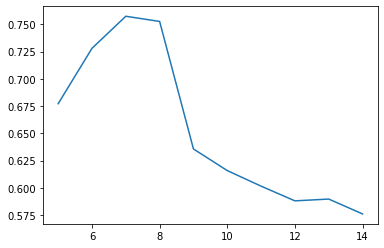

In [319]:
plt.plot(k_range, scores)

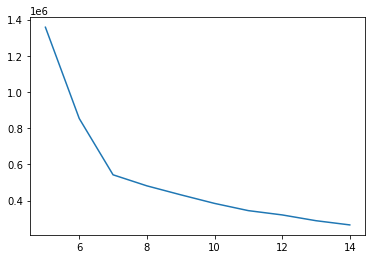

In [320]:
plt.plot(k_range, inertia)

In [321]:
cluster_size=7

In [322]:
km_colours = KMeans(n_clusters=cluster_size, random_state=124)
km_colours.fit(colours[['R', 'G', 'B']])

KMeans(n_clusters=7, random_state=124)

In [323]:
base_colours=km_colours.cluster_centers_

In [324]:
fig = px.imshow([base_colours])
fig.show()

In [325]:
colours['cluster']=km_colours.labels_.astype(str)

In [326]:
color_discrete_map={}
for i in range(0, len(base_colours)):
    color_discrete_map[str(i)]='rgb('+str(round(base_colours[i][0]))+','+str(round(base_colours[i][1]))+','+str(round(base_colours[i][2]))+')'
fig=px.scatter_ternary(colours, a='R', b='G', c='B', color='cluster', color_discrete_map=color_discrete_map)
fig.show()

## Normalise Flags Colours in conversion to DataFrame

In [327]:
colour_dictionary={}
for i in colour_list_all:
    #print(i[0:3])
    colour_dictionary[i]=km_colours.predict([[i[0], i[1], i[2]]])[0]


In [328]:
def normalised_colour_list(img, palette):
    data = img.getdata()
    colours = []
    for item in data:
        colours.append(colour_dictionary[item])
    return colours


In [329]:
cols=[x for x in range(0, len(base_colours))]
df=pd.DataFrame(columns=['Country', 'file']+cols)

In [330]:
for i in flag_list:
    colour_percentage=[0]*(len(cols))
    my_dict={}
    size=0
    flag_colours=normalised_colour_list(i[2], colour_dictionary)
    for pixel in flag_colours:
        size+=1
        if pixel in my_dict:
            my_dict[pixel]+=1
        else:
            my_dict[pixel]=1
    for k, v in dict(my_dict).items():
        colour_percentage[k]=v
    colour_percentage=[100*round(x/size, 2) for x in colour_percentage]
    df.loc[len(df)] =[i[0], i[1]]+colour_percentage

In [331]:
df

Country                               file     0     1     2     3  \
0           Iran         175px-Flag_of_Iran.svg.png   0.0  37.0   1.0  32.0   
1         Jordan       180px-Flag_of_Jordan.svg.png  28.0  20.0   0.0  25.0   
2        Georgia      150px-Flag_of_Georgia.svg.png   0.0  64.0   0.0  36.0   
3         Poland       160px-Flag_of_Poland.svg.png   0.0  50.0   0.0  50.0   
4           Fiji         180px-Flag_of_Fiji.svg.png   0.0  11.0   2.0  13.0   
..           ...                                ...   ...   ...   ...   ...   
201  Saint_Lucia  180px-Flag_of_Saint_Lucia.svg.png   3.0   3.0   7.0   0.0   
202       Belize       167px-Flag_of_Belize.svg.png   0.0   9.0   1.0  21.0   
203     Colombia     150px-Flag_of_Colombia.svg.png   0.0   0.0  50.0  25.0   
204     Slovenia     180px-Flag_of_Slovenia.svg.png   0.0  32.0   0.0  34.0   
205     Pakistan     150px-Flag_of_Pakistan.svg.png  67.0  31.0   0.0   0.0   

        4     5     6  
0     0.0  29.0   2.0  
1     0.0  28.0   0.0  
2     0.0   0.0   0.0  
3     0.0   0.0   0.0  
4     7.0   1.0  66.0  
..    ...   ...   ...  
201   0.0   0.0  86.0  
202  64.0   4.0   1.0  
203  25.0   0.0   0.0  
204   0.0   0.0  34.0  
205   0.0   1.0   1.0  

[206 rows x 9 columns]

## Cleaning up Names

In [332]:
#df['Country'].unique()

In [333]:

df['Country']=df['Country'].str.replace('%C3%B4', 'ô')
df['Country']=df['Country'].str.replace('_%28converted%29', '')
df['Country']=df['Country'].str.replace('_%28Pantone%29', '')
df['Country']=df['Country'].str.replace('_%28civil%29', '')
df['Country']=df['Country'].str.replace('_', ' ')
df['Country']=df['Country'].str.replace('%27', '\'')

In [334]:
#df['Country'].unique()

## Clustering by colour percentage

In [335]:
X=df[[x for x in range(0, len(base_colours))]]

In [336]:
k_range = range(5, 100)
scores= []
inertia = []
for k in k_range:
    kmT= KMeans(n_clusters=k, random_state=124)
    kmT.fit(X)
    scores.append(metrics.silhouette_score(X, kmT.labels_))
    inertia.append(kmT.inertia_)

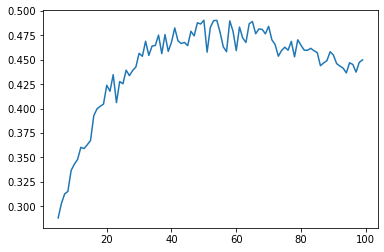

In [337]:
plt.plot(k_range, scores)

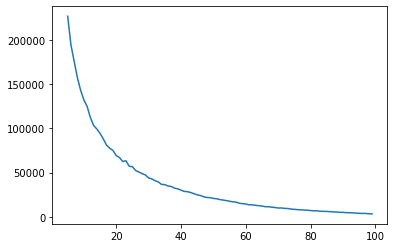

In [338]:
plt.plot(k_range, inertia)

In [339]:
#z=list(zip(k_range, scores))
#for i in z:
#    print(i)

In [340]:
cluster_size=22

In [341]:
km = KMeans(n_clusters=cluster_size, random_state=124)
km.fit(X)
df['colour_cluster']=km.labels_

In [342]:
df

Country                               file     0     1     2     3  \
0           Iran         175px-Flag_of_Iran.svg.png   0.0  37.0   1.0  32.0   
1         Jordan       180px-Flag_of_Jordan.svg.png  28.0  20.0   0.0  25.0   
2        Georgia      150px-Flag_of_Georgia.svg.png   0.0  64.0   0.0  36.0   
3         Poland       160px-Flag_of_Poland.svg.png   0.0  50.0   0.0  50.0   
4           Fiji         180px-Flag_of_Fiji.svg.png   0.0  11.0   2.0  13.0   
..           ...                                ...   ...   ...   ...   ...   
201  Saint Lucia  180px-Flag_of_Saint_Lucia.svg.png   3.0   3.0   7.0   0.0   
202       Belize       167px-Flag_of_Belize.svg.png   0.0   9.0   1.0  21.0   
203     Colombia     150px-Flag_of_Colombia.svg.png   0.0   0.0  50.0  25.0   
204     Slovenia     180px-Flag_of_Slovenia.svg.png   0.0  32.0   0.0  34.0   
205     Pakistan     150px-Flag_of_Pakistan.svg.png  67.0  31.0   0.0   0.0   

        4     5     6  colour_cluster  
0     0.0  29.0   2.0               9  
1     0.0  28.0   0.0              11  
2     0.0   0.0   0.0              18  
3     0.0   0.0   0.0              10  
4     7.0   1.0  66.0               3  
..    ...   ...   ...             ...  
201   0.0   0.0  86.0               3  
202  64.0   4.0   1.0               4  
203  25.0   0.0   0.0               5  
204   0.0   0.0  34.0              17  
205   0.0   1.0   1.0               8  

[206 rows x 10 columns]

In [343]:
def view_cluster(data, cluster):
    pics=[]
    labels=[]
    names=[]
    for i in range(0, data[cluster].nunique()):
        cluster_list=[]
        im_u=data[data[cluster]==i]['file'].tolist()
        l=data[data[cluster]==i][cluster].tolist()
        n=data[data[cluster]==i]['Country'].tolist()
        for j in im_u:
            cluster_list.append(Image.open('flags/'+str(j)))
        pics.extend(cluster_list)
        labels.extend(l)
        names.extend(n)
    ipyplot.plot_class_tabs(pics, labels, custom_texts=names)

/usr/lib/python3.9/site-packages/numpy/core/_asarray.py:102: FutureWarning:

The input object of type 'PngImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'PngImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.




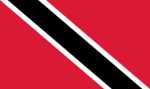
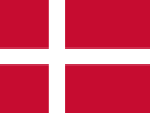
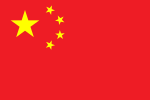
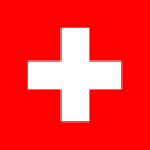
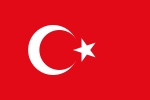
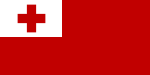
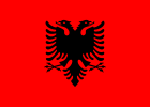
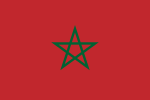
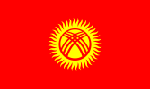
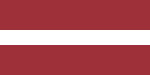
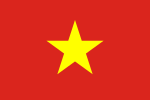
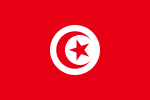
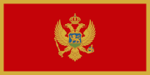
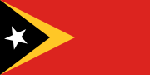
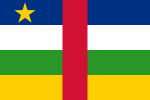
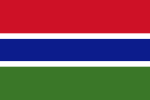
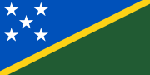
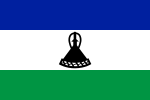
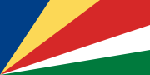
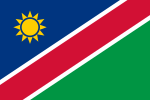
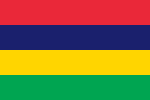
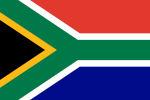
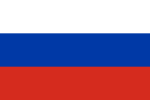
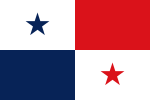
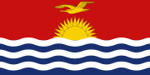
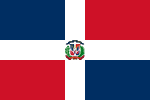
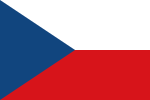
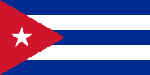
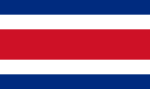
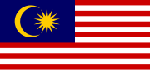
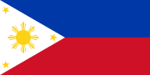
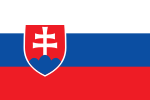
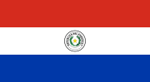
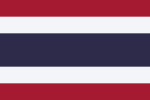
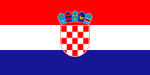
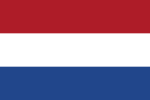
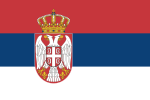
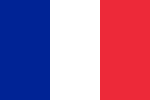
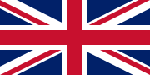
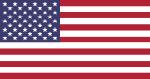
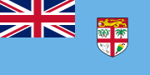
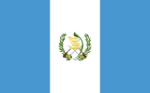
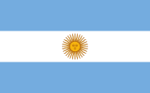
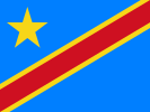
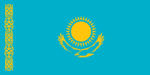
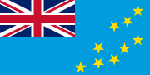
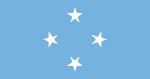
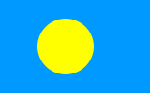
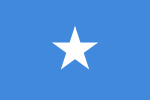
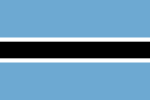
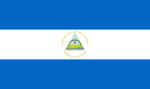
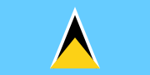
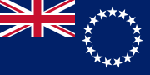
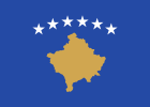
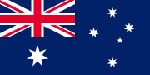
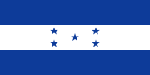
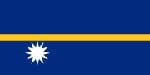
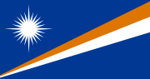
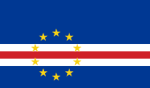
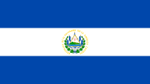
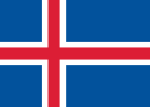
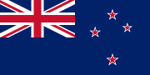
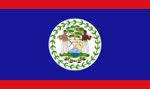
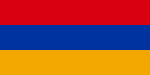
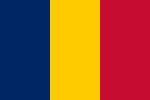
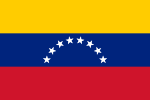
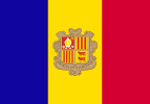
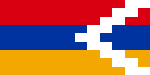
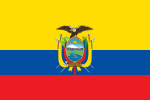
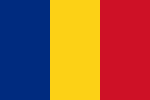
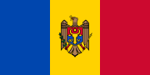
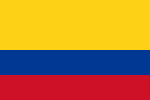
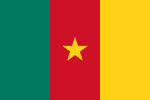
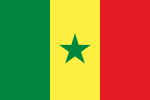
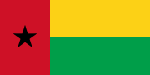
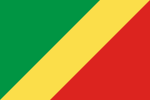
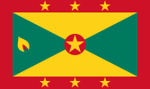
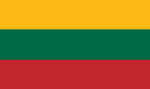
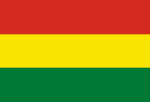
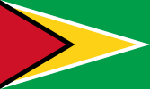
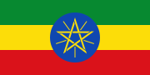
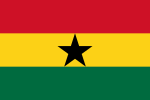
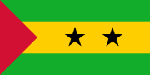
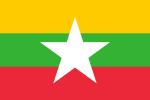
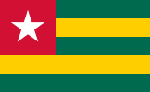
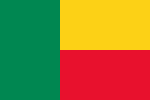
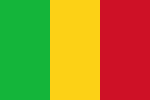
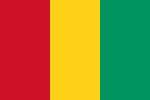
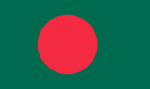
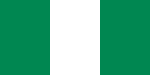
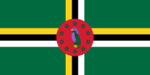
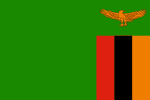
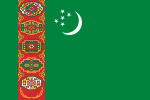
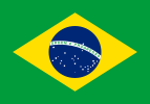
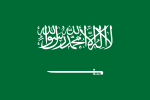
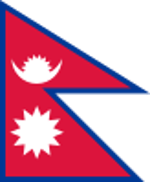
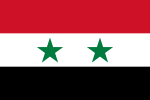
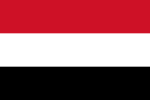
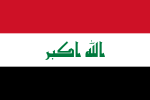
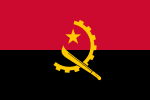
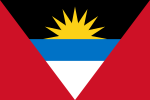
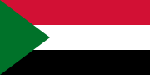
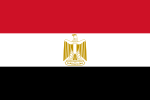
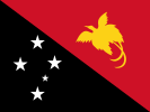
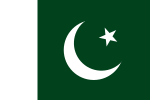
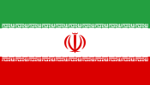
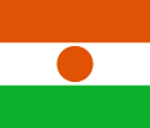
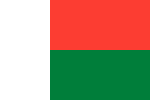
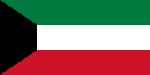
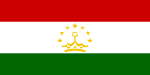
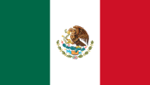
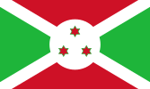
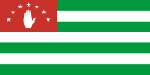
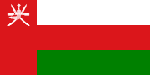
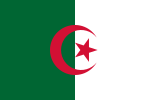
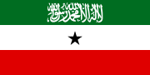
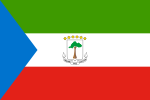
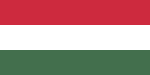
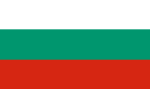
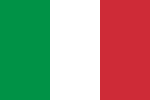
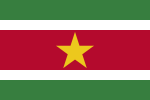
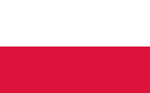
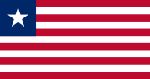
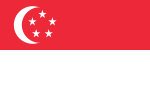
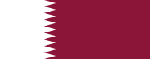
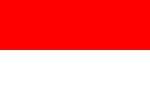
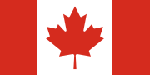
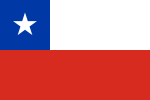
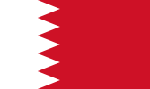
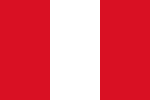
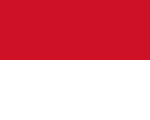
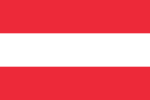
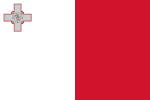
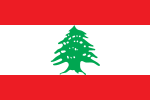
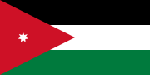
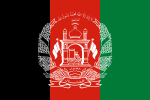
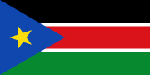
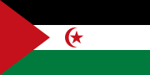
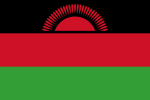
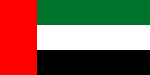
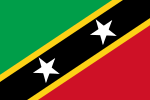
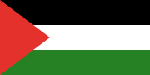
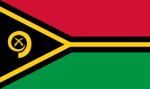
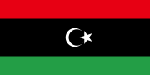
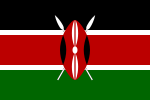
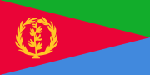
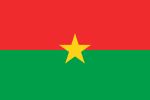
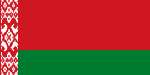
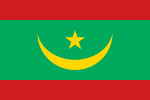
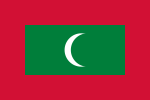
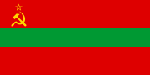
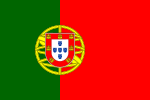
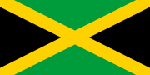
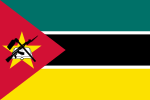
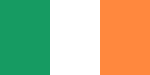
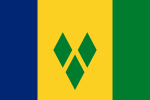
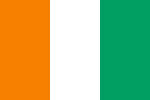
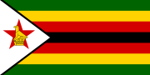
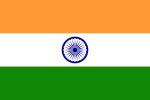
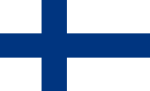
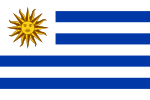
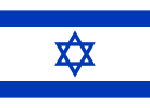
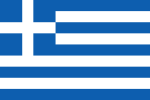
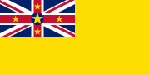
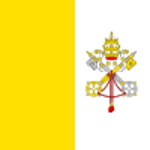
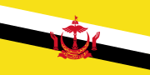
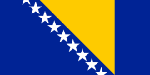
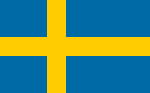
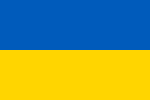
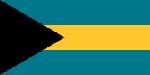
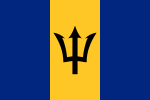
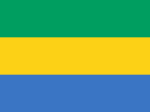
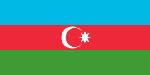
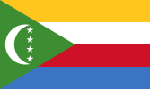
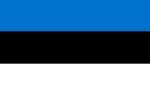
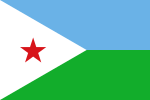
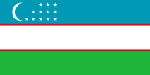
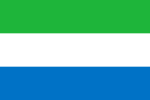
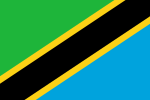
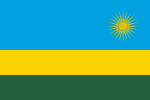
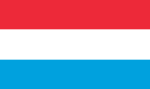
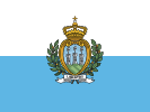
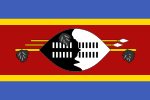
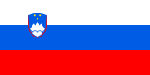
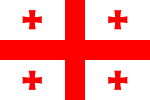
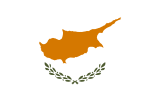
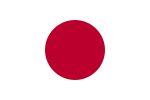
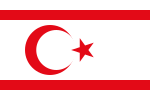
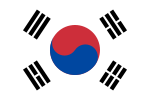
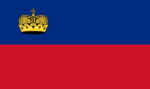
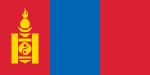
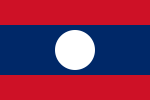
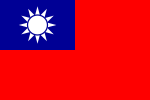
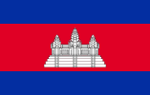
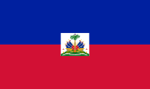
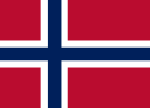
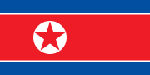
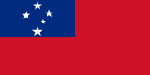
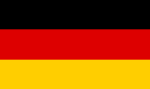
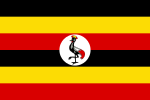
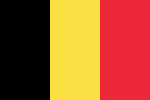
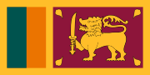
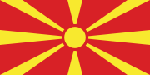
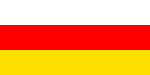
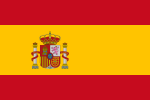
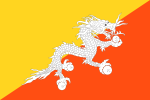


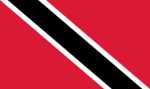
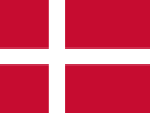
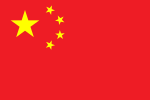
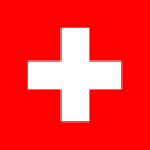
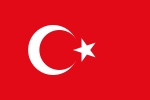
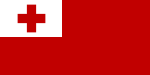
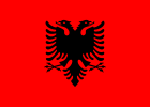
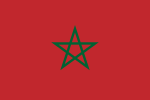
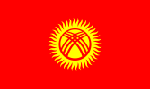
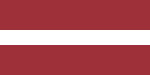
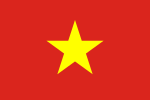
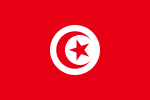
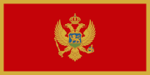
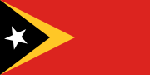
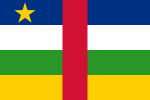
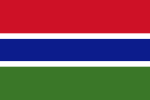
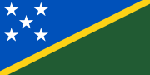
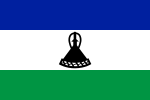
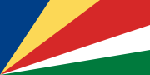
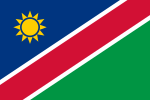
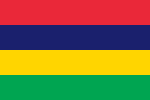
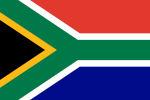
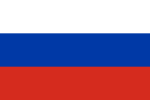
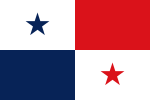
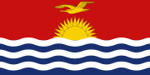
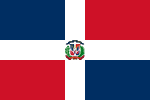
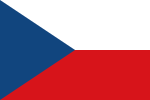
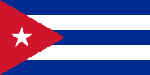
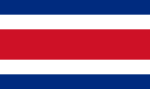
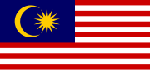
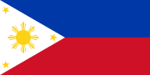
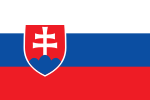
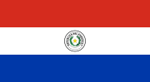
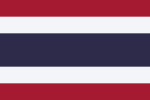
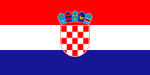
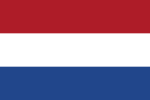
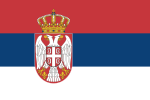
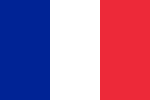
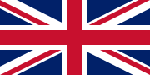
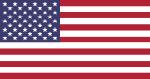
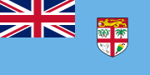
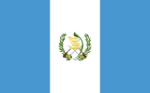
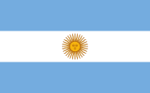
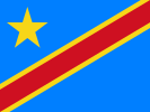
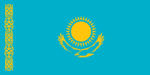
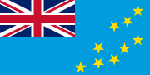
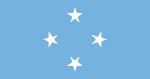
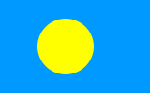
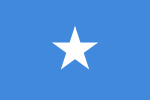
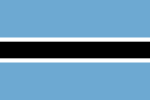
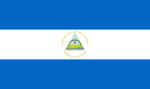
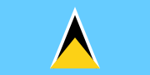
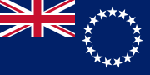
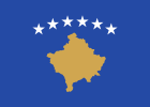
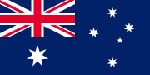
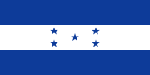
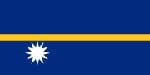
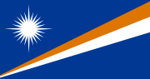
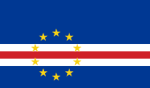
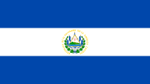
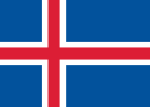
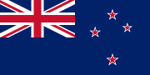
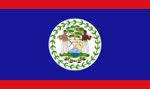
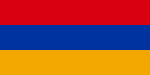
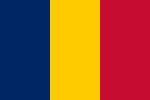
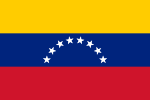
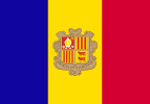
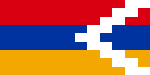
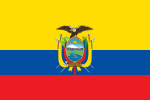
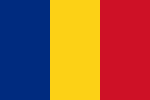
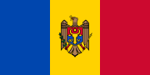
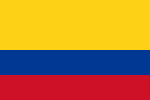
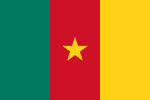
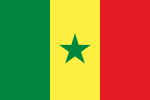
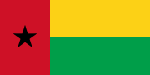
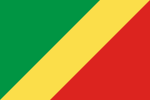
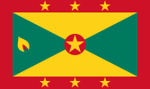
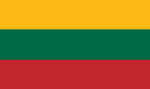
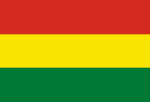
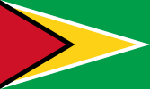
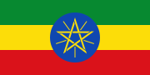
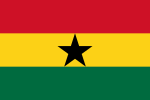
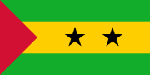
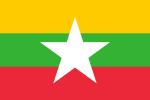
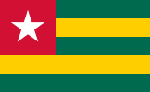
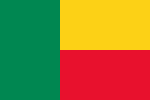
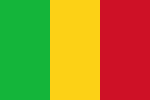
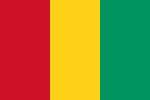
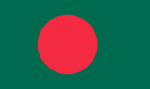
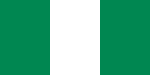
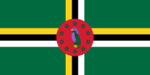
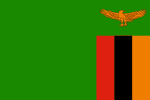
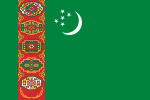
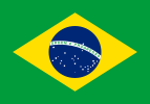
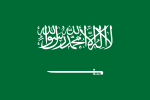
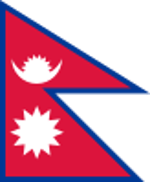
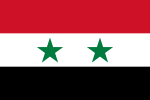
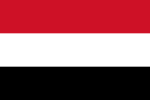
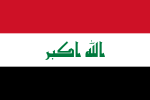
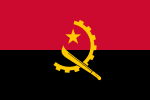
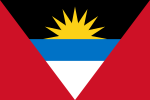
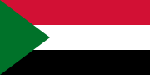
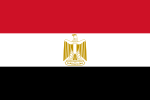
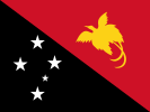
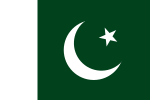
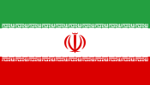
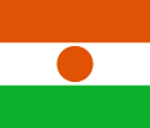
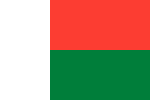
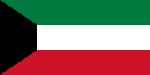
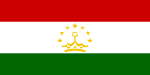
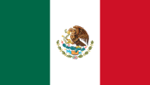
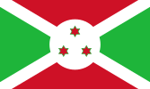
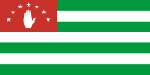
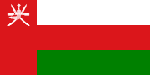
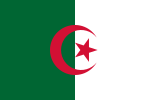
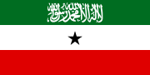
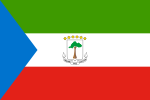
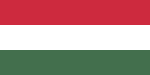
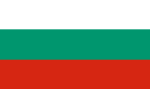
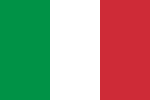
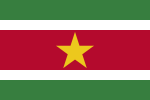
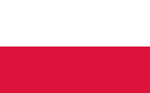
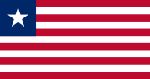
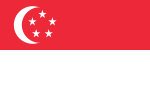
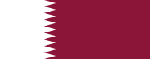
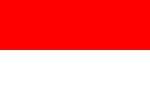
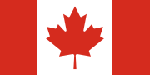
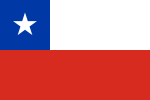
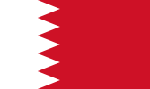
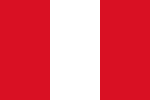
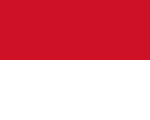
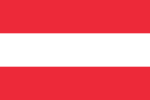
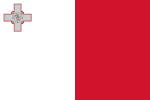
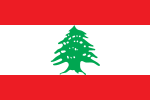
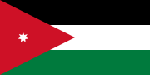
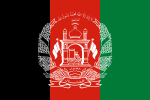
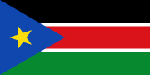
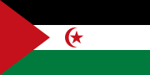
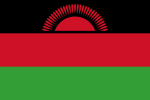
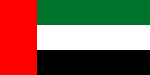
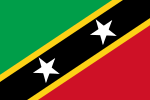
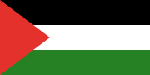
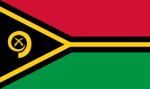
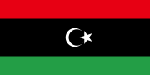
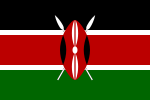
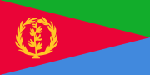
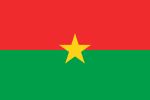
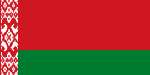
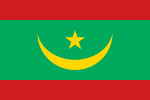
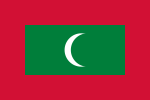
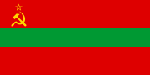
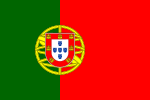
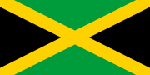
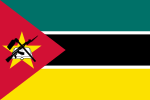
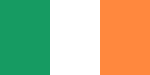
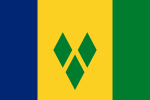
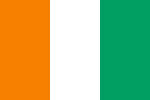
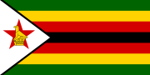
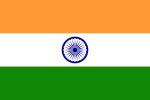
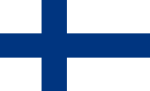
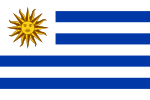
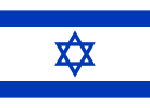
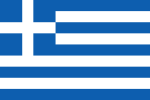
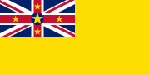
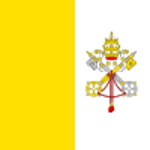
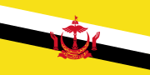
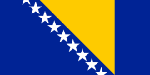
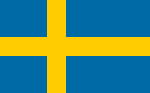
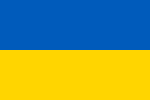
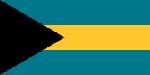
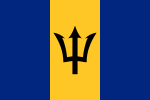
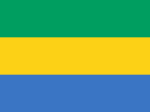
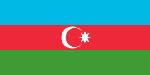
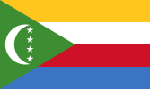
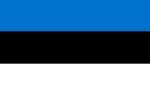
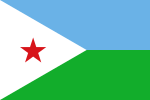
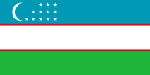
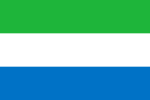
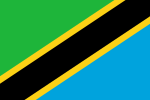
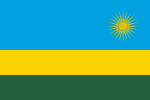
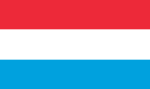
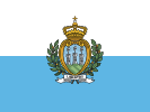
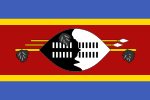
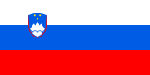
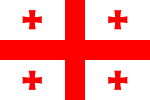
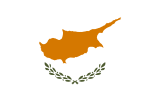
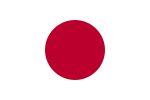
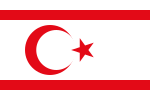
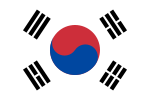
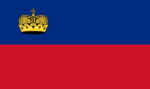
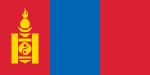
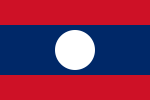
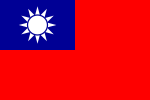
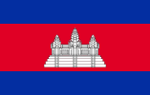
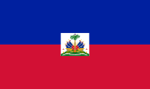
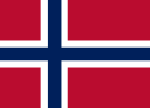
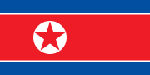
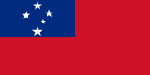
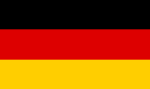
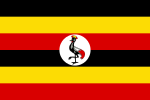
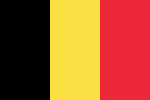
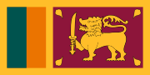
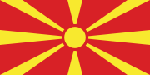
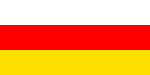
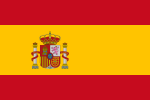
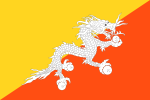

In [344]:
view_cluster(df, 'colour_cluster')

# Edge Cluster

In [345]:
#flag_norm=[]
flag_edges=[]
for i in flag_list:
    im=i[2]
    #im_c=im.convert('RGB')
    im_g=ImageOps.grayscale(im)
    #im_c = np.array(im_c)
    im_g = np.array(im_g)
    #im_c=skimage.transform.resize(im_c, (100, 180))
    im_g=skimage.transform.resize(im_g, (100, 180))
    edges = skimage.feature.canny(
        image=im_g,
        sigma=0,
        low_threshold=0,
        high_threshold=0.01,
    )
    #flag_norm.append(im_c)
    flag_edges.append(edges)
flag_edges=np.array(flag_edges)

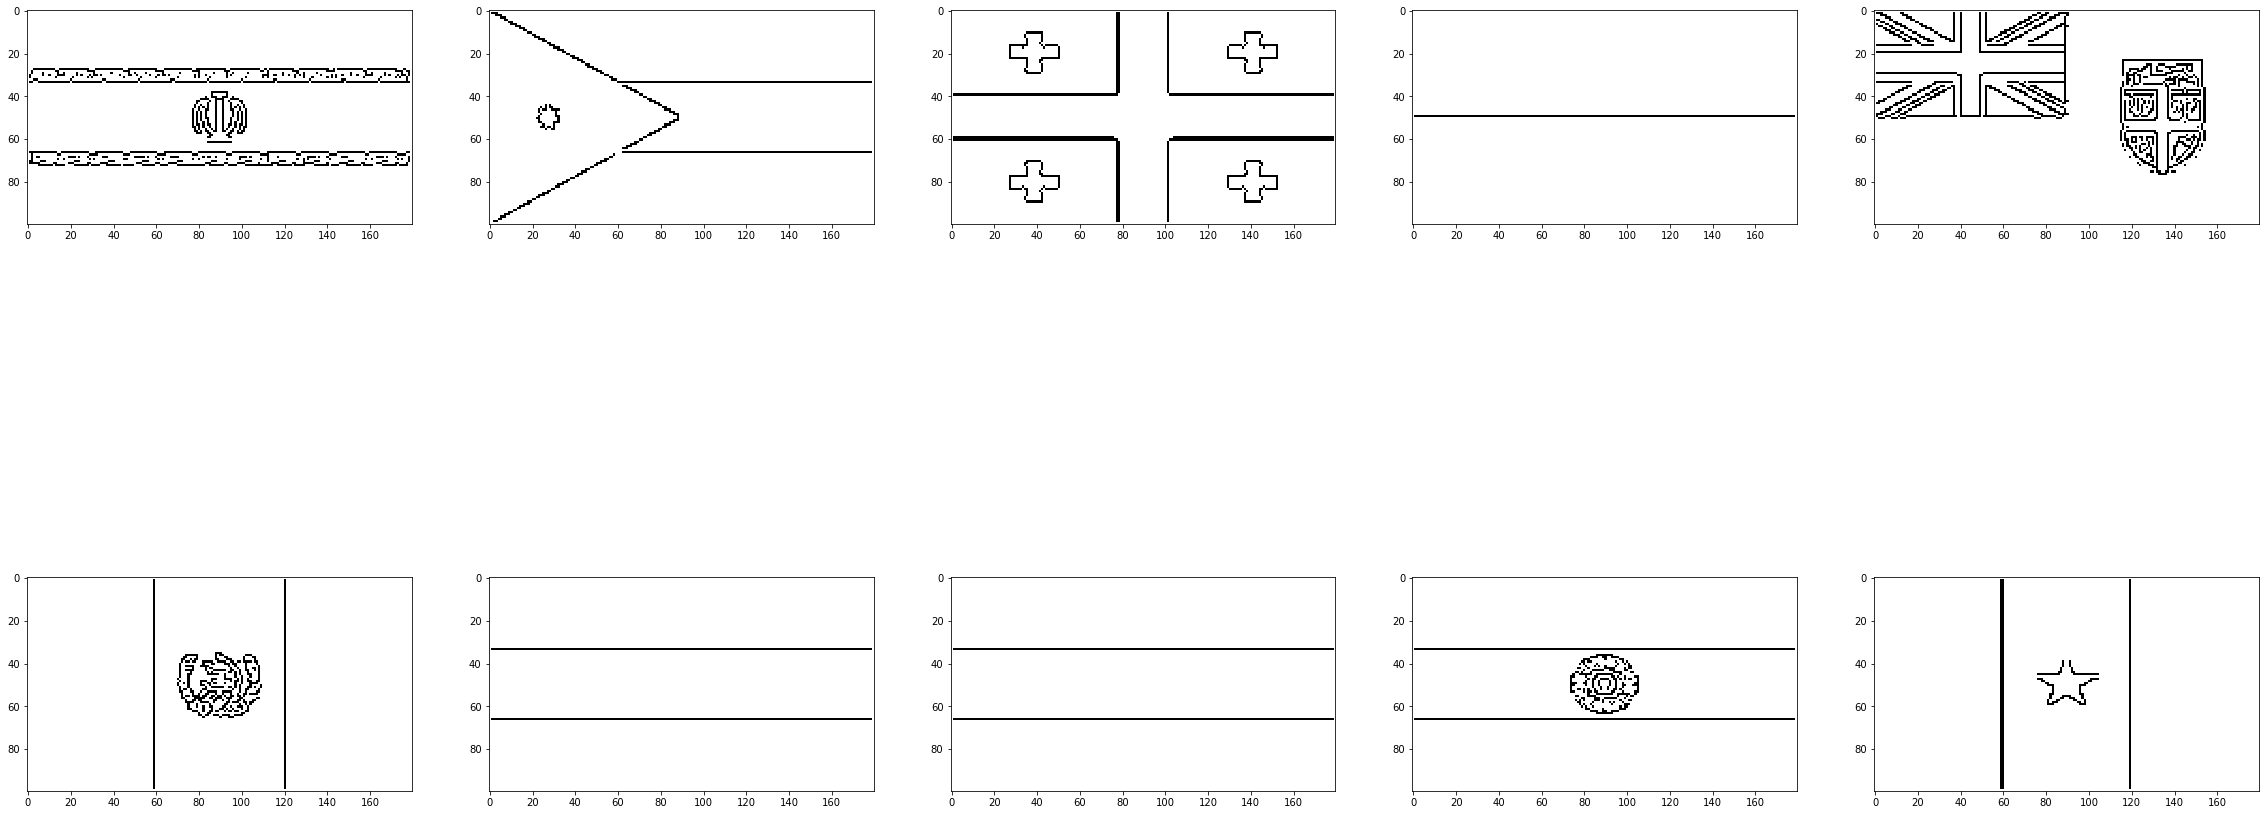

In [346]:
plt.figure(figsize=(40,40))
for i, image in enumerate(flag_edges[:10]):
    #initializing subplot of 3x5
    plt.subplot(4,5, i+1)
    #display images in the subplots
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

In [347]:
x = preprocess_input(flag_edges)
model=VGG16(weights=None, classes=25,input_shape=(100, 180, 1))
model= Model(inputs=model.inputs, outputs=model.layers[-2].output)
f=model.predict(x)

In [348]:
pca=PCA(n_components=100, random_state=22)
pca.fit(f)
x=pca.transform(f)

In [349]:
k_range = range(5, 60)
scores= []
inertia = []
for k in k_range:
    kmT= KMeans(n_clusters=k, random_state=124)
    kmT.fit(x)
    scores.append(metrics.silhouette_score(x, kmT.labels_))
    inertia.append(kmT.inertia_)

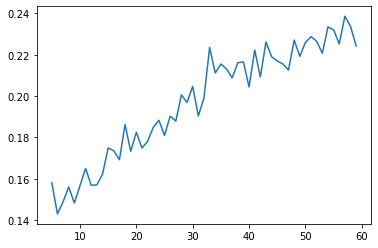

In [350]:
plt.plot(k_range, scores)

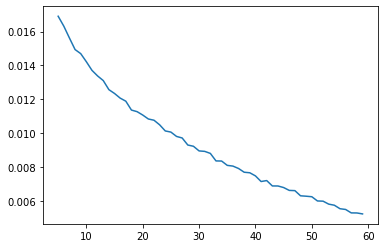

In [351]:
plt.plot(k_range, inertia)

In [352]:
z=list(zip(k_range, scores))
for i in z:
    print(i)

(5, 0.15812095)
(6, 0.14302963)
(7, 0.14887558)
(8, 0.15607852)
(9, 0.14829776)
(10, 0.15668607)
(11, 0.16502695)
(12, 0.15682243)
(13, 0.1571108)
(14, 0.16220859)
(15, 0.17489654)
(16, 0.17352362)
(17, 0.16925146)
(18, 0.1862173)
(19, 0.17327805)
(20, 0.18252045)
(21, 0.17488402)
(22, 0.178131)
(23, 0.18485148)
(24, 0.18831655)
(25, 0.18096402)
(26, 0.19025947)
(27, 0.18791124)
(28, 0.20058118)
(29, 0.19691658)
(30, 0.20467985)
(31, 0.1903589)
(32, 0.19907506)
(33, 0.22349007)
(34, 0.21115653)
(35, 0.21549484)
(36, 0.21313436)
(37, 0.20877734)
(38, 0.21613708)
(39, 0.21647346)
(40, 0.20443147)
(41, 0.22223645)
(42, 0.20924078)
(43, 0.22616485)
(44, 0.21901292)
(45, 0.21696462)
(46, 0.215533)
(47, 0.21255599)
(48, 0.22705916)
(49, 0.21926595)
(50, 0.22592404)
(51, 0.22869474)
(52, 0.22648384)
(53, 0.22068235)
(54, 0.23342033)
(55, 0.23200548)
(56, 0.22522317)
(57, 0.23858994)
(58, 0.23370703)
(59, 0.22421736)


In [353]:
cluster_size=31

In [354]:
km = KMeans(n_clusters=cluster_size, random_state=124)
km.fit(x)
df['edge_cluster']=km.labels_

/usr/lib/python3.9/site-packages/numpy/core/_asarray.py:102: FutureWarning:

The input object of type 'PngImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'PngImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.




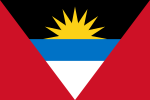
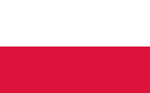
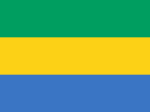
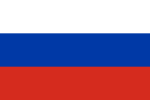
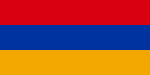
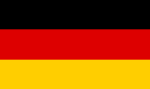
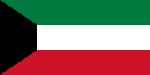
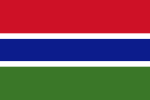
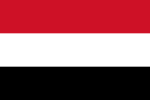
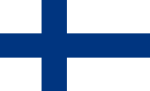
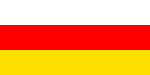
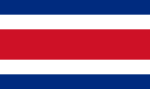
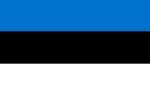
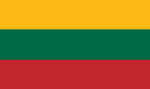
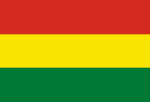
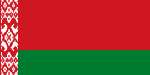
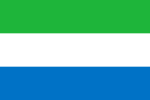
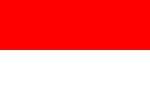
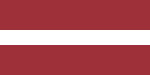
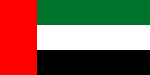
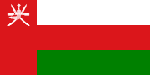
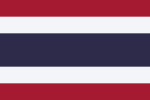
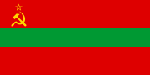
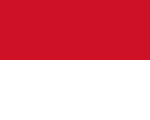
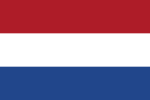
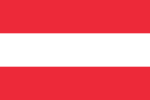
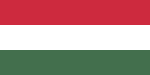
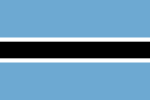
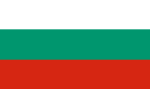
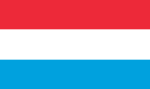
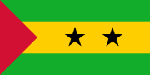
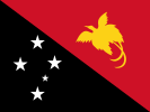
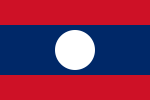
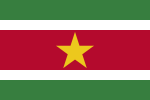
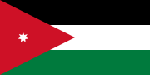
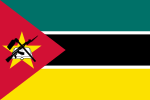
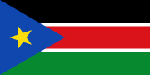
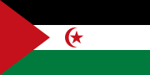
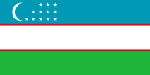
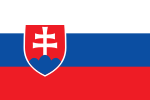
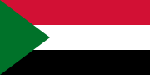
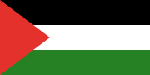
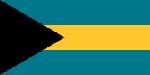
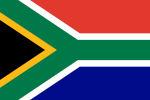
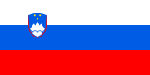
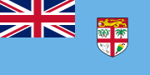
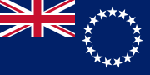
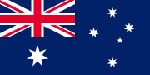
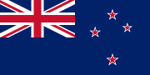
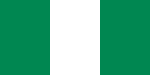
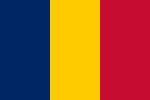
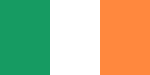
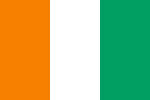
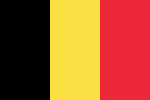
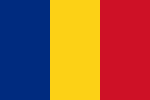
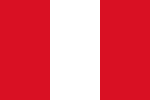
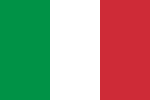
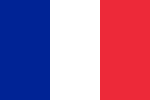
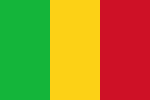
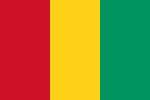
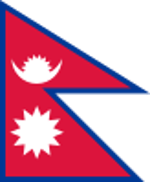
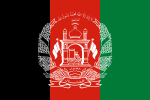
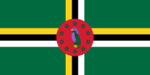
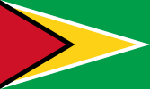
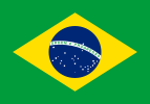
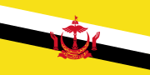
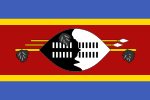
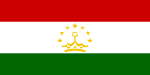
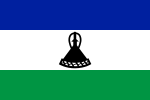
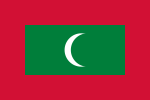
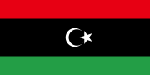
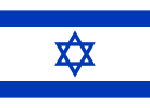
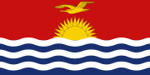
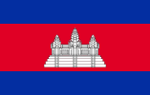
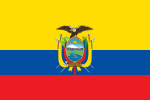
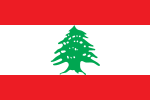
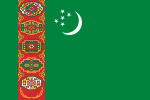
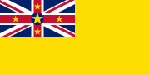
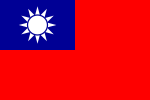
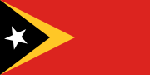
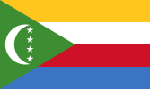
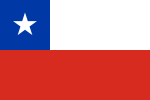
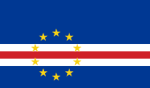
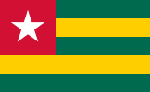
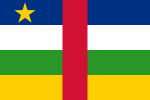
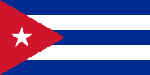
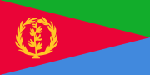
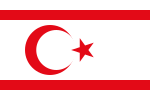
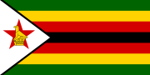
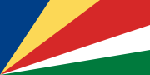
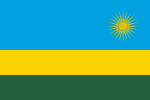
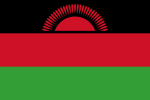
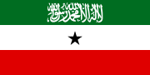
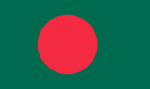
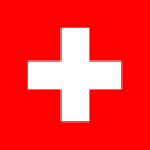
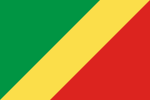
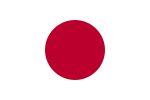
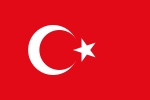
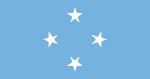
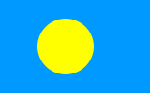
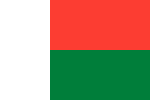
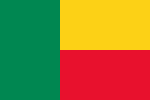
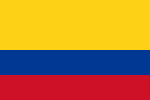
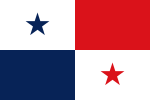
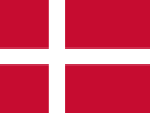
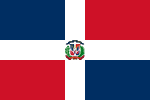
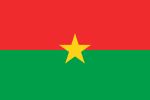
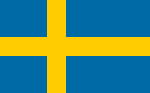
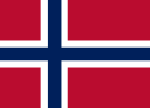
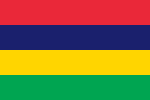
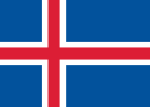
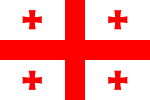
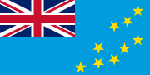
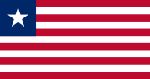
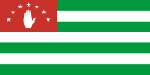
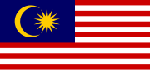
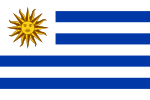
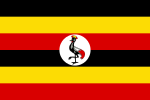
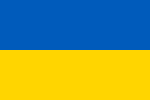
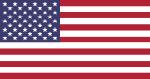
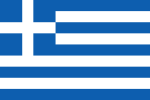
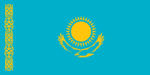
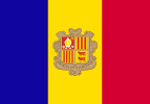
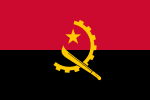
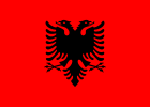
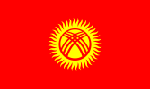
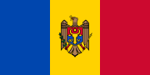
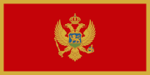
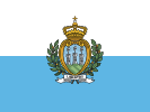
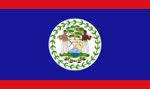
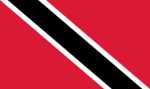
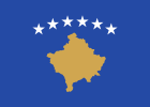
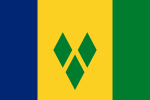
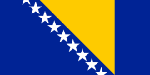
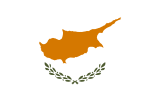
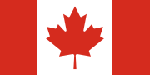
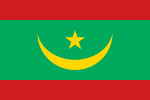
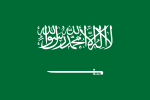
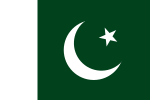
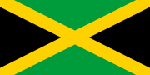
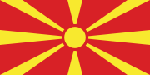
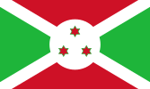
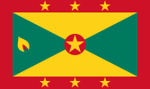
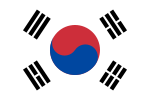
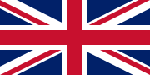
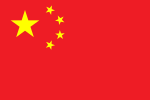
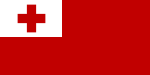
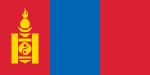
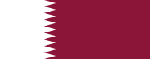
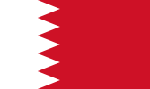
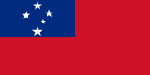
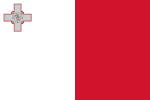
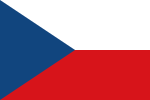
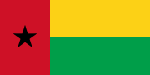
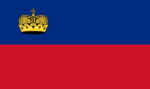
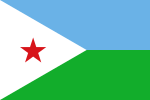
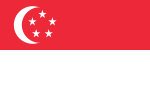
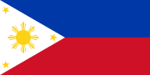
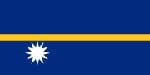
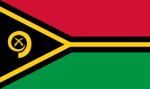
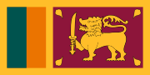
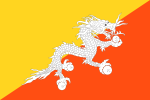
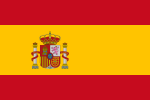
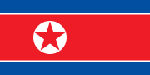
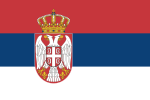
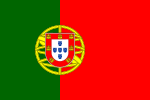
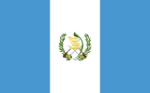
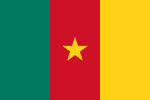
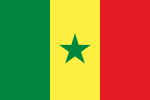
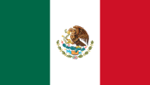
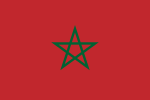
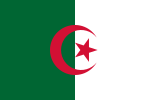
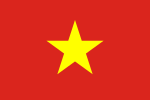
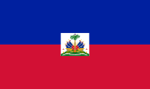
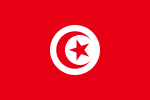
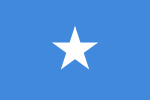
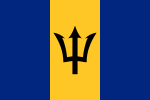
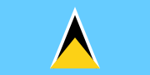
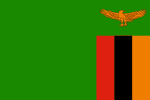
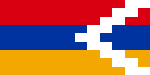
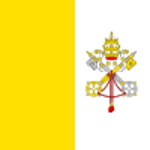
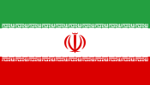
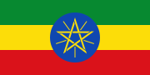
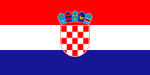
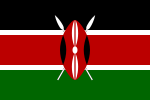
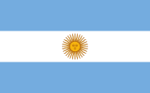
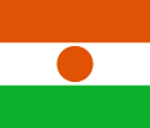
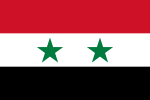
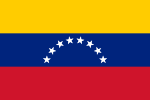
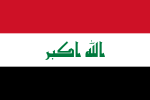
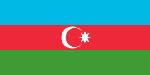
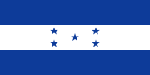
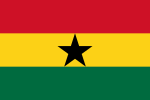
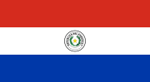
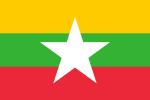
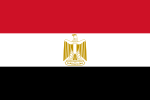
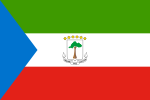
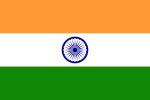
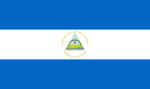
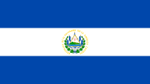
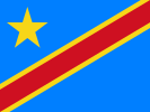
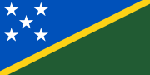
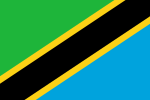
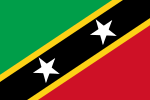
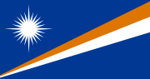
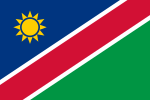


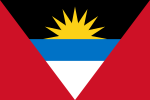
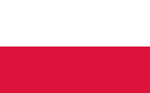
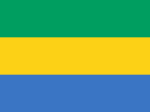
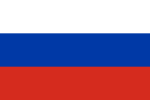
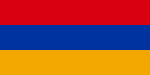
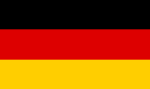
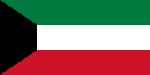
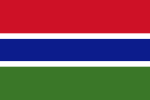
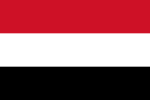
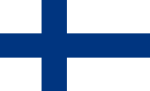
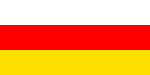
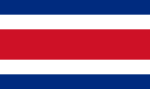
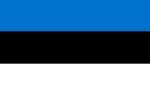
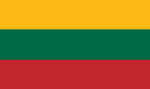
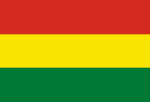
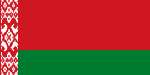
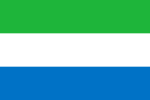
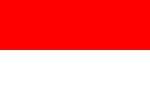
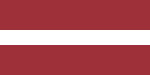
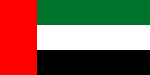
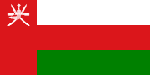
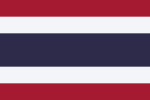
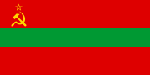
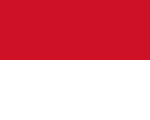
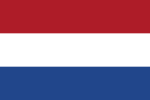
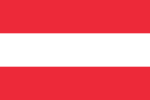
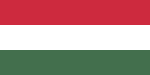
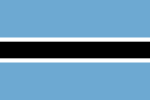
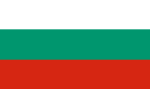
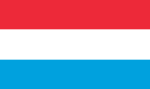
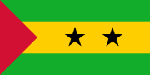
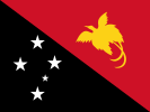
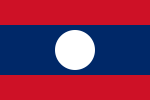
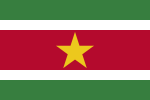
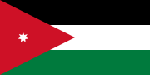
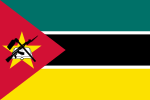
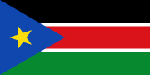
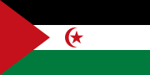
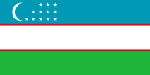
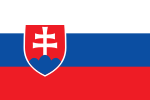
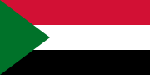
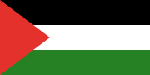
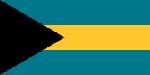
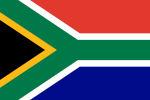
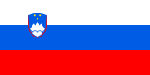
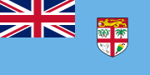
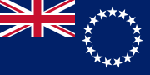
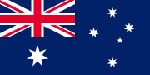
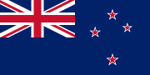
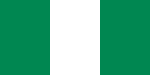
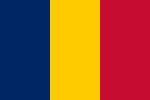
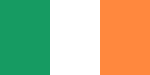
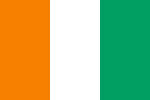
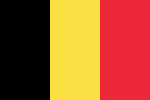
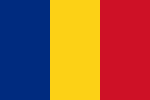
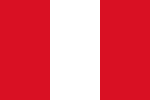
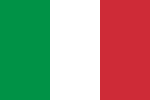
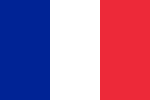
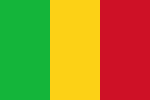
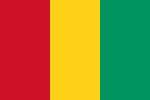
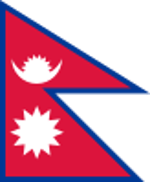
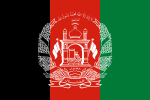
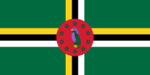
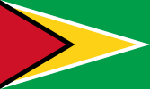
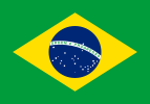
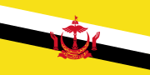
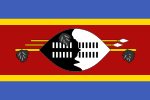
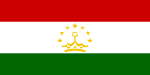
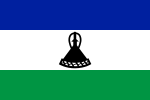
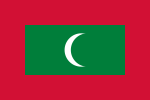
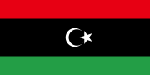
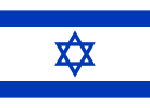
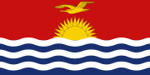
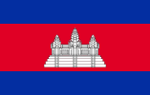
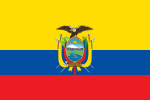
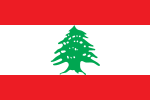
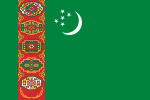
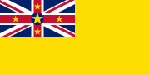
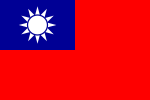
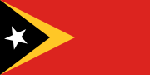
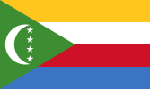
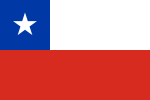
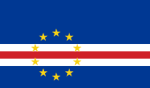
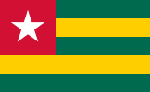
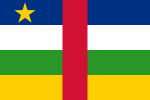
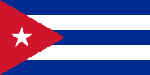
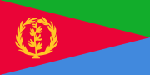
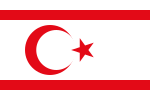
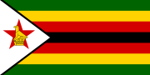
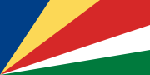
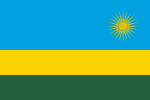
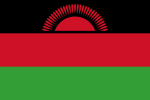
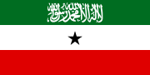
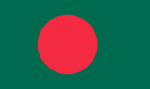
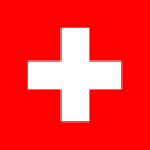
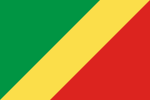
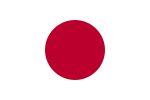
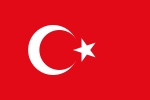
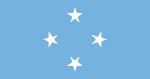
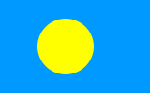
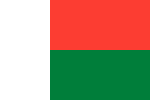
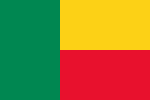
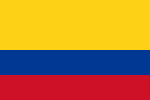
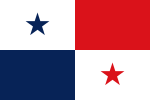
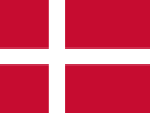
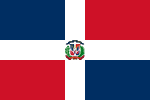
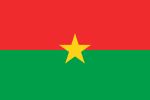
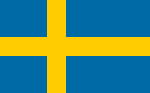
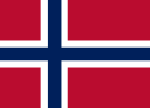
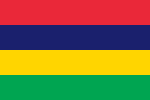
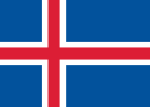
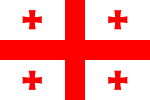
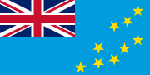
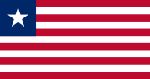
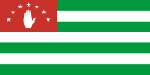
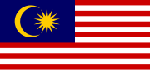
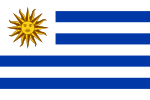
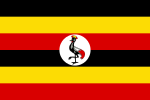
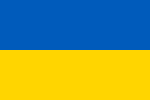
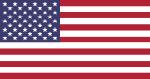
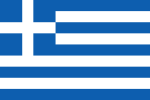
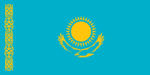
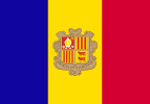
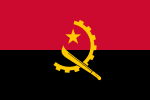
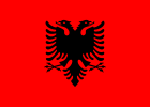
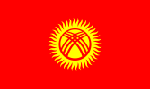
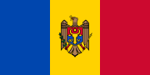
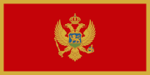
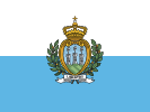
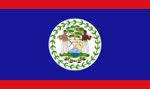
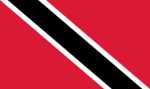
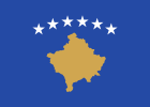
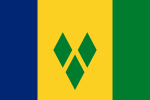
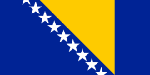
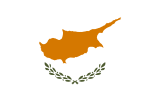
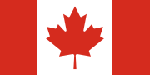
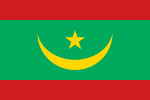
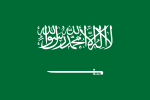
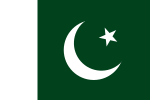
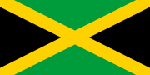
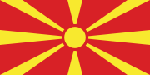
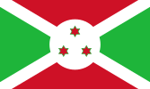
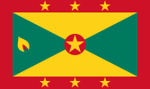
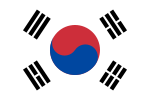
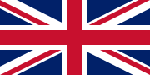
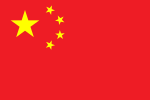
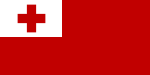
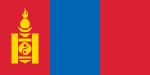
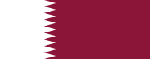
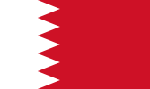
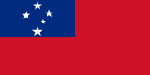
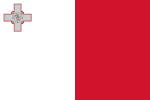
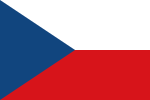
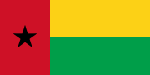
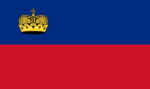
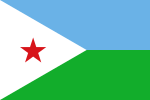
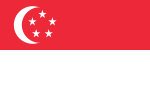
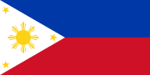
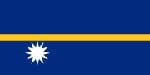
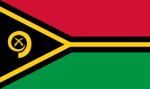
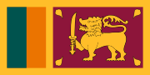
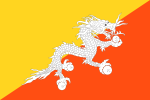
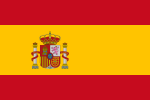
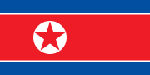
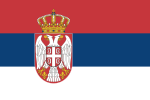
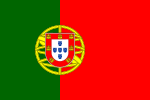
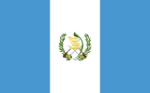
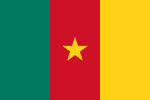
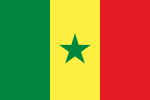
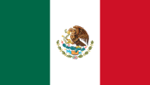
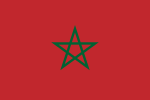
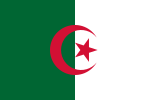
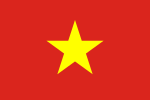
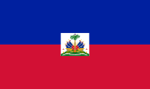
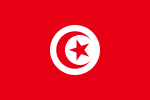
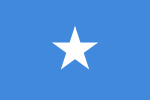
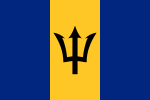
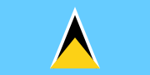
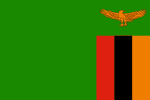
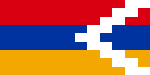
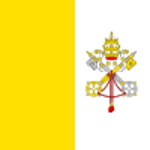
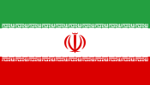
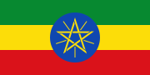
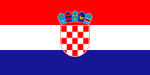
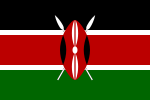
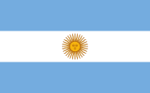
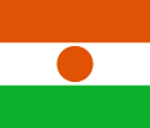
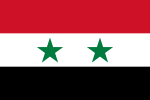
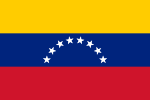
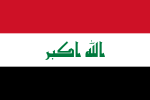
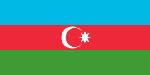
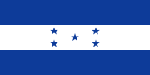
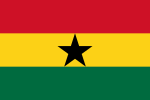
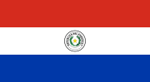
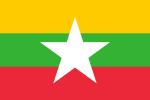
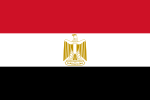
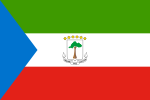
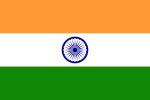
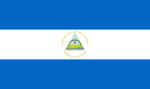
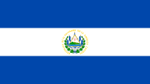
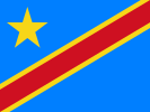
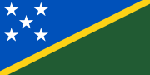
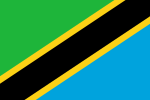
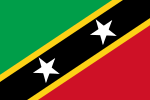
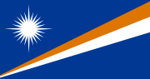
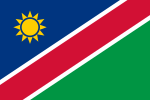

In [355]:
view_cluster(df, 'edge_cluster')

# Combine colour and edge clusters

In [356]:
df

Country                               file     0     1     2     3  \
0           Iran         175px-Flag_of_Iran.svg.png   0.0  37.0   1.0  32.0   
1         Jordan       180px-Flag_of_Jordan.svg.png  28.0  20.0   0.0  25.0   
2        Georgia      150px-Flag_of_Georgia.svg.png   0.0  64.0   0.0  36.0   
3         Poland       160px-Flag_of_Poland.svg.png   0.0  50.0   0.0  50.0   
4           Fiji         180px-Flag_of_Fiji.svg.png   0.0  11.0   2.0  13.0   
..           ...                                ...   ...   ...   ...   ...   
201  Saint Lucia  180px-Flag_of_Saint_Lucia.svg.png   3.0   3.0   7.0   0.0   
202       Belize       167px-Flag_of_Belize.svg.png   0.0   9.0   1.0  21.0   
203     Colombia     150px-Flag_of_Colombia.svg.png   0.0   0.0  50.0  25.0   
204     Slovenia     180px-Flag_of_Slovenia.svg.png   0.0  32.0   0.0  34.0   
205     Pakistan     150px-Flag_of_Pakistan.svg.png  67.0  31.0   0.0   0.0   

        4     5     6  colour_cluster  edge_cluster  
0     0.0  29.0   2.0               9            28  
1     0.0  28.0   0.0              11             4  
2     0.0   0.0   0.0              18            17  
3     0.0   0.0   0.0              10             1  
4     7.0   1.0  66.0               3             5  
..    ...   ...   ...             ...           ...  
201   0.0   0.0  86.0               3            26  
202  64.0   4.0   1.0               4            18  
203  25.0   0.0   0.0               5            15  
204   0.0   0.0  34.0              17             4  
205   0.0   1.0   1.0               8            19  

[206 rows x 11 columns]

In [357]:
df['edge_cluster']=df['edge_cluster'].astype('str')
df['colour_cluster']=df['colour_cluster'].astype('str')

### Using colour percentages and edge cluster dummies

In [358]:
#df = pd.concat([df,pd.get_dummies(df['edge_cluster'], prefix='shape')],axis=1)

In [359]:
#combined=df.drop(['Country', 'file', 'colour_cluster', 'edge_cluster'], axis=1)

In [360]:
#combined

In [361]:
#X=scaler.fit_transform(combined)

In [362]:
#k_range = range(5, 100)
#scores= []
#inertia = []
#for k in k_range:
#    kmT= KMeans(n_clusters=k, random_state=124)
#    kmT.fit(X)
#    scores.append(metrics.silhouette_score(X, kmT.labels_))
#    inertia.append(kmT.inertia_)

In [363]:
#plt.plot(k_range, scores)

In [364]:
#plt.plot(k_range, inertia)

In [365]:
#z=list(zip(k_range, scores))
#for i in z:
#    print(i)

In [366]:
#cluster_size=14

In [367]:
#km = KMeans(n_clusters=cluster_size, random_state=124)
#km.fit(X)
#df['combined']=km.labels_

In [368]:
#view_cluster(df, 'combined')

### Using colour dummies and shape dummies

In [369]:
c=df[['colour_cluster', 'edge_cluster']]

In [370]:
c=pd.get_dummies(c)
c


colour_cluster_0  colour_cluster_1  colour_cluster_10  colour_cluster_11  \
0                   0                 0                  0                  0   
1                   0                 0                  0                  1   
2                   0                 0                  0                  0   
3                   0                 0                  1                  0   
4                   0                 0                  0                  0   
..                ...               ...                ...                ...   
201                 0                 0                  0                  0   
202                 0                 0                  0                  0   
203                 0                 0                  0                  0   
204                 0                 0                  0                  0   
205                 0                 0                  0                  0   

     colour_cluster_12  colour_cluster_13  colour_cluster_14  \
0                    0                  0                  0   
1                    0                  0                  0   
2                    0                  0                  0   
3                    0                  0                  0   
4                    0                  0                  0   
..                 ...                ...                ...   
201                  0                  0                  0   
202                  0                  0                  0   
203                  0                  0                  0   
204                  0                  0                  0   
205                  0                  0                  0   

     colour_cluster_15  colour_cluster_16  colour_cluster_17  ...  \
0                    0                  0                  0  ...   
1                    0                  0                  0  ...   
2                    0                  0                  0  ...   
3                    0                  0                  0  ...   
4                    0                  0                  0  ...   
..                 ...                ...                ...  ...   
201                  0                  0                  0  ...   
202                  0                  0                  0  ...   
203                  0                  0                  0  ...   
204                  0                  0                  1  ...   
205                  0                  0                  0  ...   

     edge_cluster_28  edge_cluster_29  edge_cluster_3  edge_cluster_30  \
0                  1                0               0                0   
1                  0                0               0                0   
2                  0                0               0                0   
3                  0                0               0                0   
4                  0                0               0                0   
..               ...              ...             ...              ...   
201                0                0               0                0   
202                0                0               0                0   
203                0                0               0                0   
204                0                0               0                0   
205                0                0               0                0   

     edge_cluster_4  edge_cluster_5  edge_cluster_6  edge_cluster_7  \
0                 0               0               0               0   
1                 1               0               0               0   
2                 0               0               0               0   
3                 0               0               0               0   
4                 0               1               0               0   
..              ...             ...             ...             ...   
201               0               0             

In [371]:
X=scaler.fit_transform(c)

In [372]:
k_range = range(5, 100)
scores= []
inertia = []
for k in k_range:
    kmT= KMeans(n_clusters=k, random_state=124)
    kmT.fit(X)
    scores.append(metrics.silhouette_score(X, kmT.labels_))
    inertia.append(kmT.inertia_)

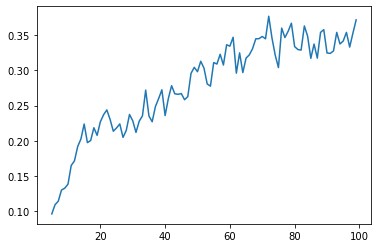

In [373]:
plt.plot(k_range, scores)

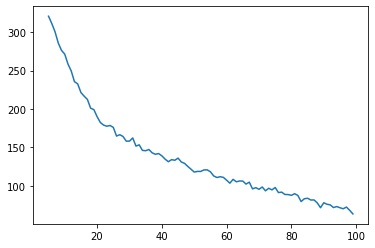

In [374]:
plt.plot(k_range, inertia)

In [375]:
#z=list(zip(k_range, scores))
#for i in z:
#    print(i)

In [376]:
cluster_size=25

In [377]:
km = KMeans(n_clusters=cluster_size, random_state=124)
km.fit(X)
df['combined2']=km.labels_

/usr/lib/python3.9/site-packages/numpy/core/_asarray.py:102: FutureWarning:

The input object of type 'PngImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'PngImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.




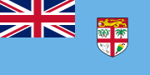
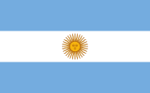
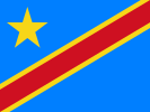
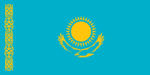
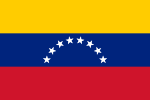
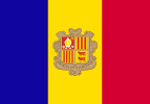
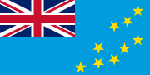
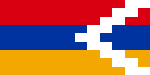
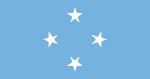
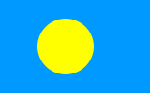
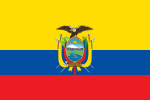
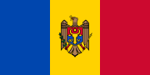
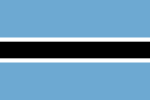
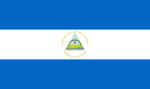
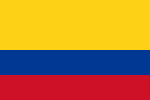
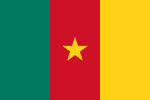
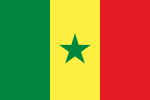
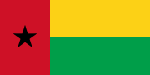
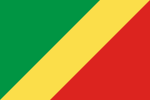
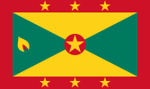
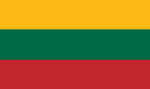
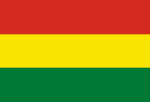
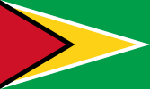
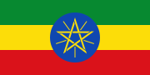
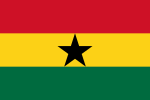
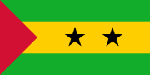
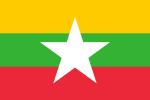
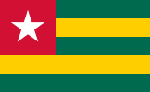
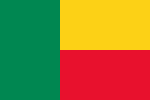
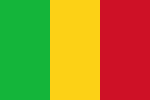
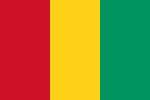
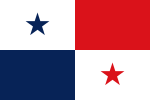
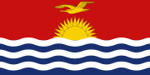
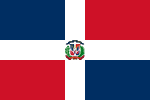
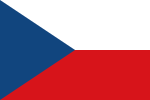
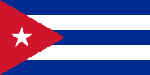
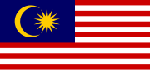
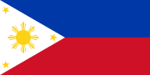
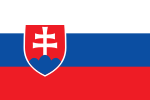
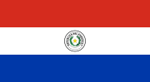
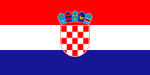
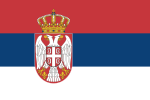
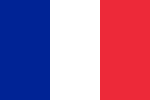
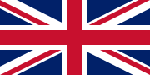
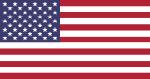
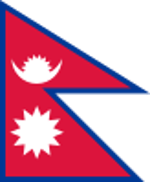
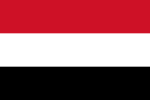
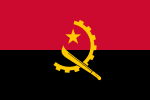
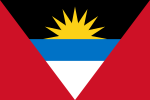
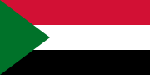
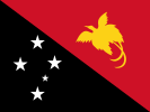
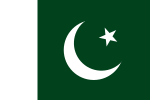
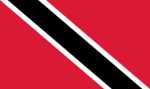
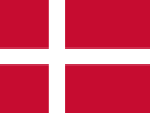
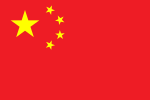
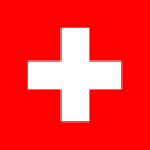
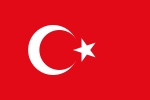
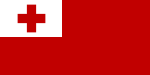
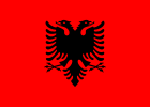
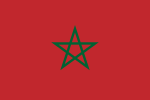
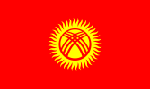
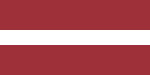
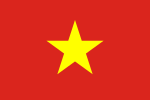
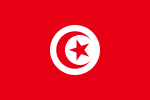
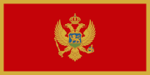
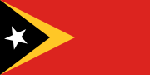
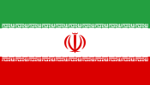
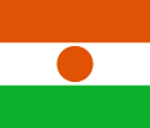
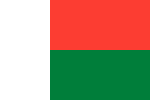
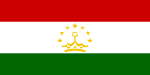
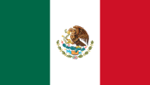
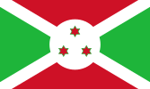
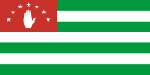
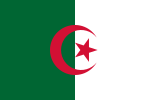
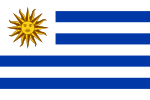
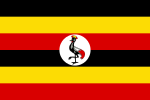
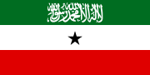
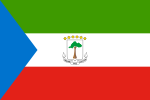
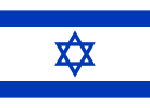
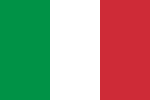
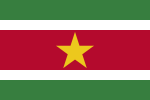
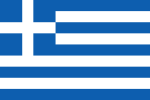
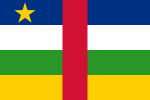
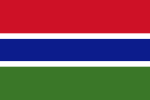
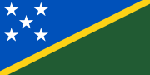
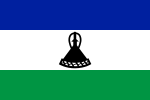
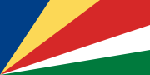
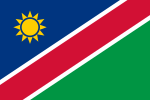
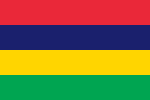
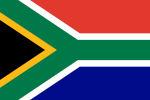
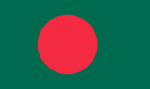
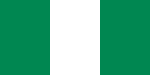
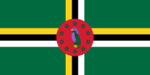
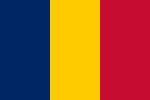
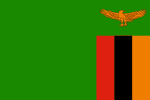
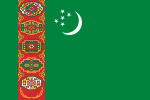
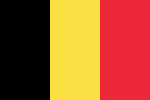
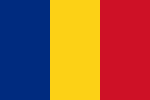
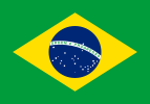
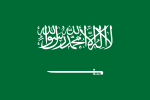
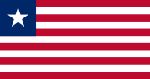
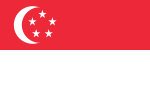
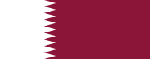
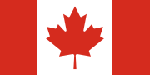
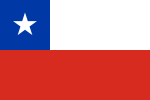
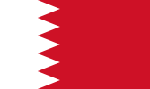
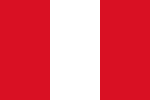
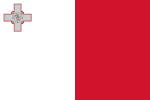
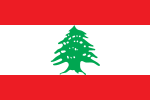
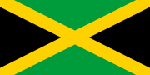
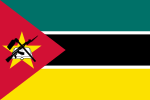
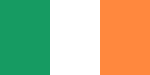
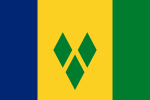
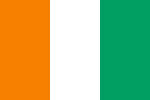
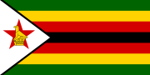
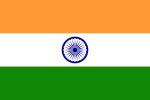
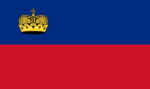
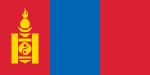
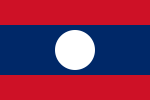
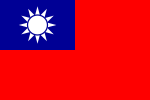
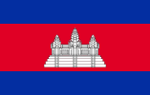
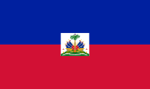
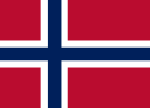
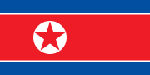
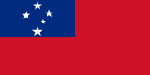
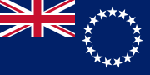
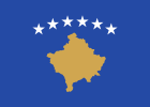
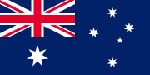
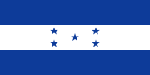
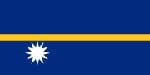
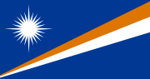
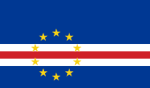
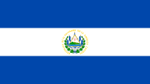
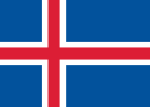
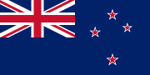
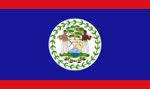
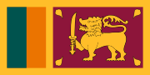
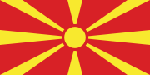
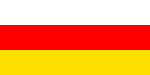
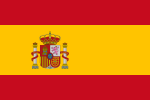
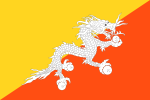
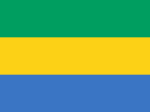
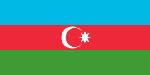
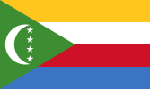
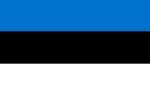
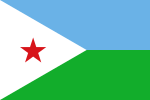
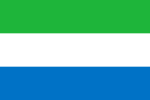
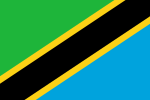
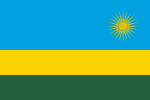
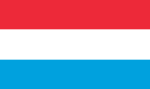
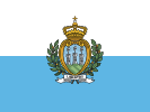
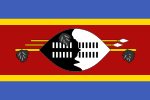
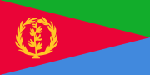
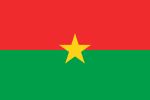
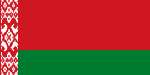
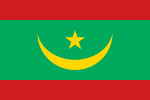
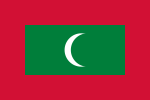
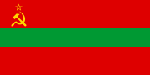
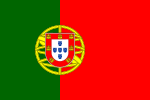
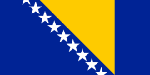
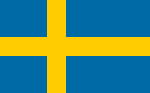
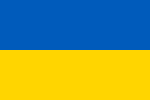
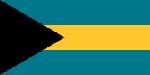
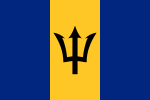
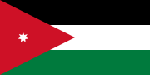
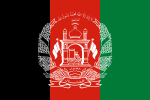
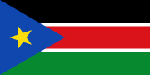
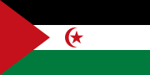
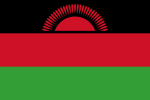
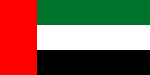
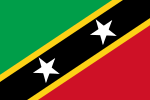
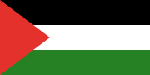
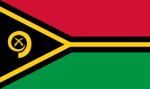
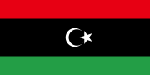
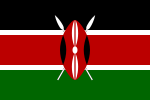
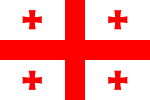
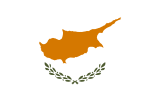
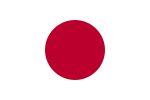
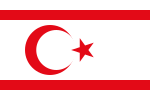
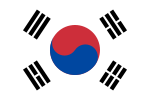
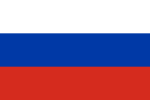
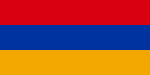
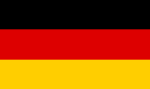
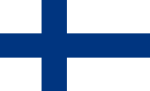
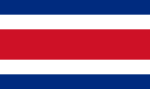
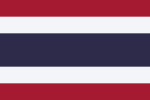
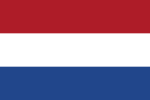
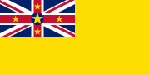
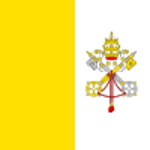
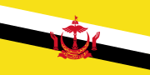
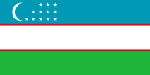
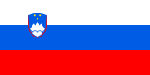
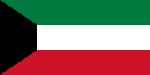
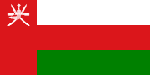
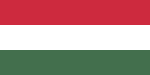
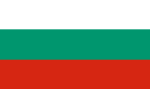
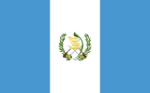
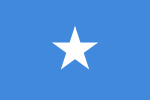
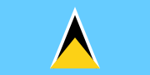
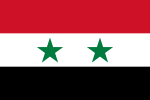
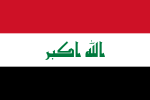
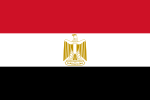
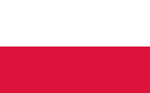
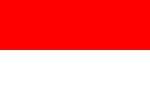
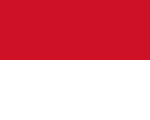
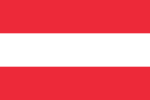


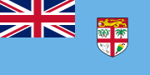
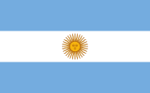
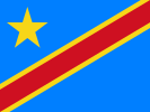
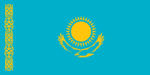
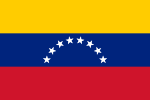
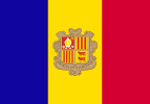
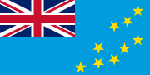
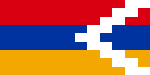
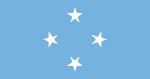
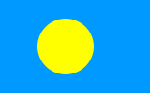
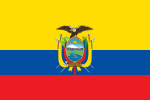
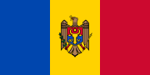
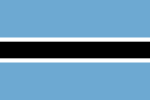
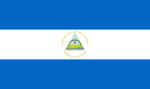
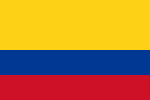
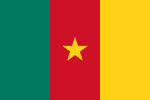
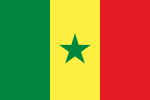
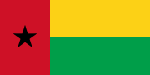
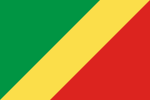
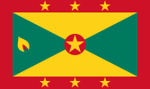
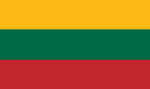
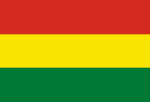
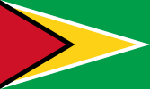
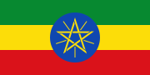
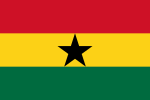
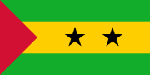
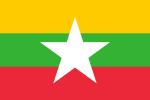
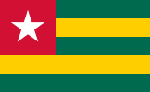
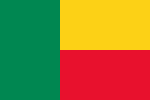
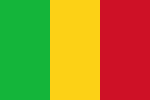
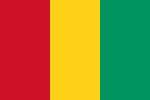
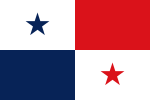
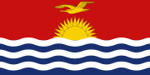
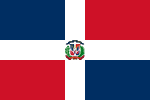
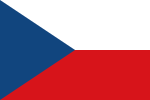
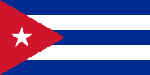
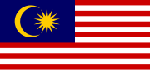
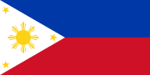
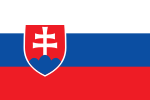
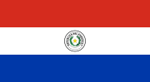
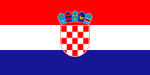
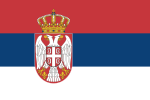
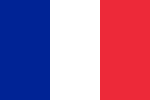
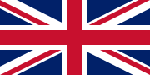
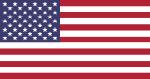
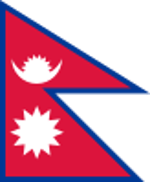
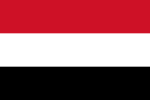
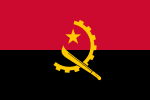
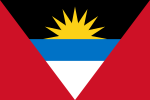
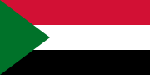
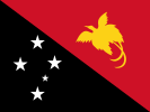
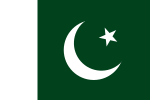
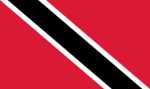
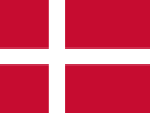
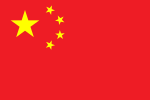
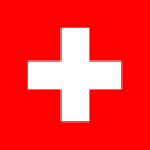
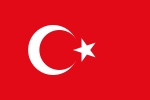
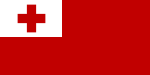
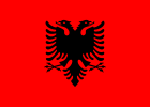
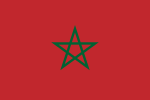
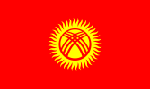
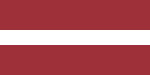
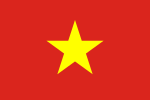
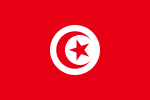
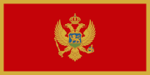
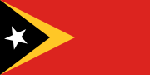
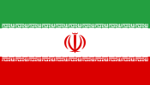
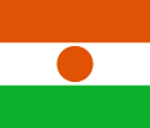
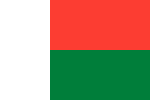
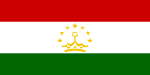
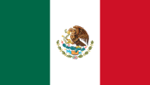
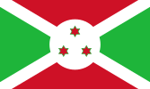
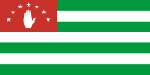
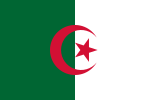
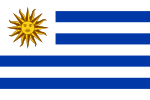
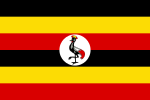
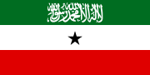
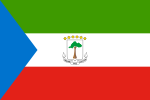
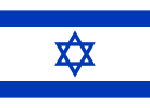
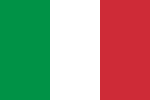
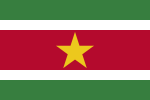
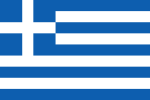
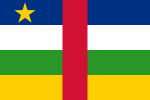
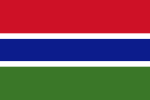
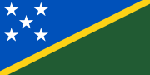
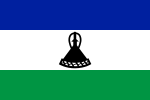
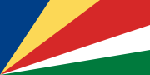
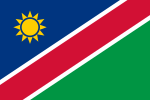
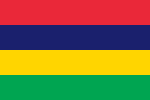
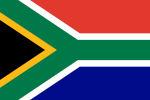
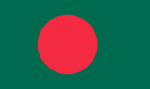
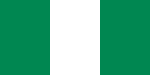
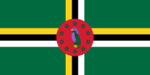
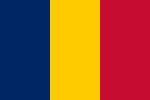
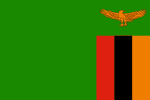
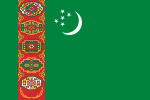
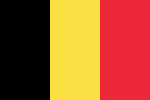
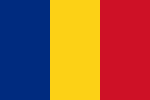
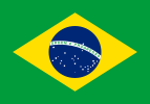
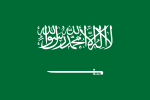
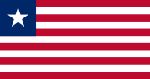
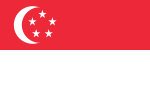
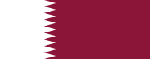
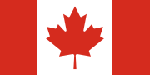
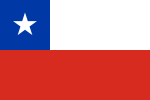
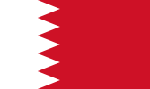
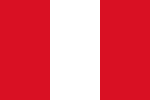
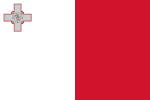
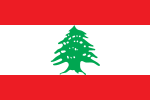
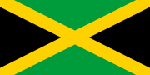
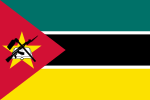
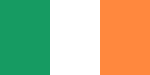
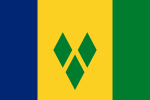
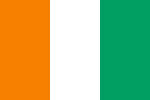
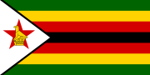
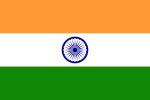
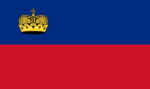
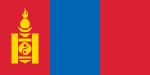
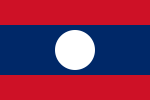
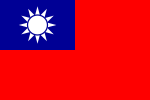
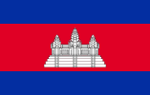
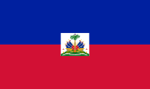
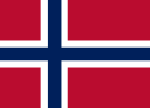
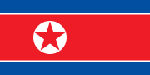
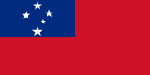
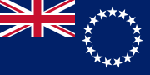
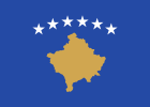
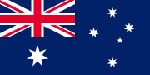
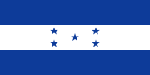
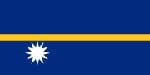
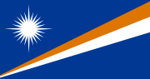
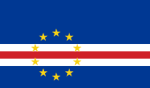
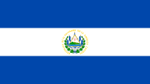
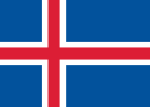
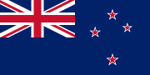
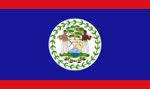
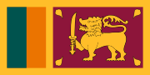
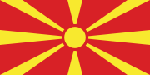
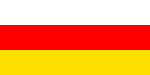
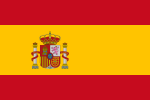
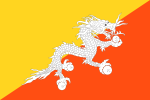
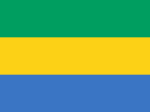
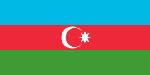
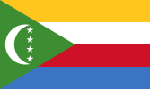
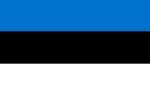
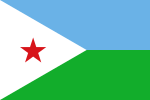
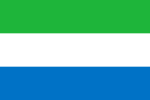
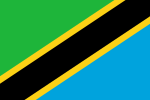
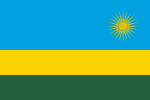
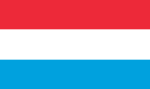
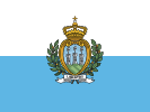
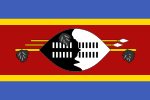
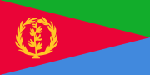
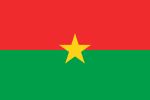
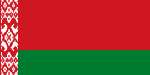
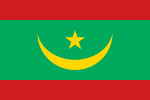
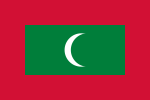
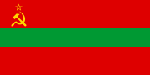
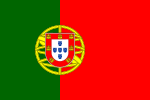
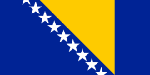
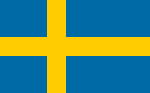
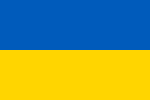
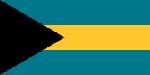
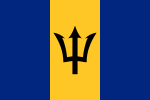
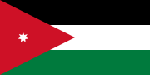
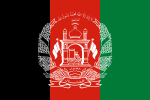
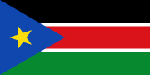
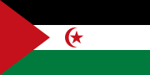
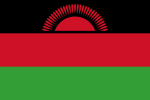
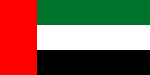
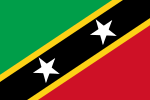
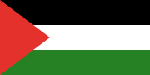
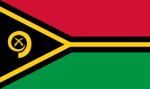
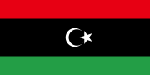
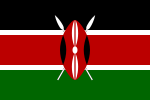
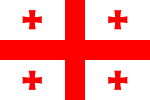
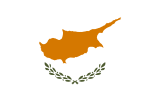
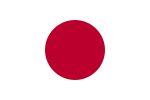
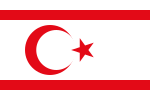
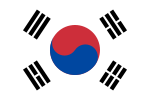
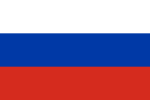
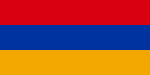
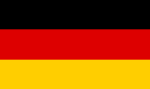
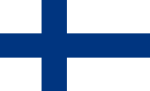
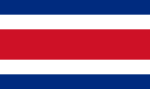
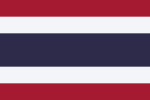
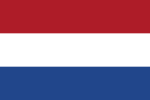
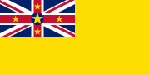
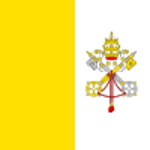
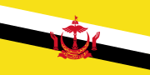
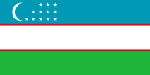
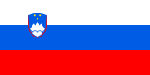
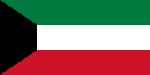
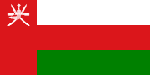
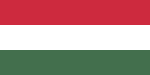
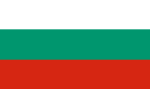
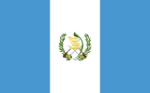
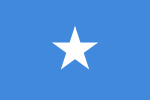
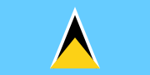
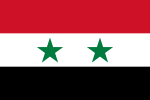
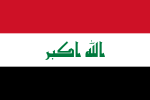
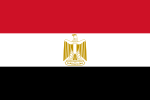
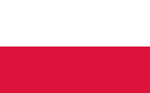
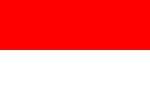
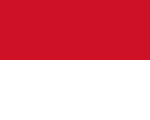
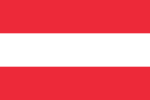

In [378]:
view_cluster(df, 'combined2')

# Supervised

In [379]:
df_s=df[['Country', 'edge_cluster', 'colour_cluster']]

## Drop useless Columns

In [380]:
bad_c=['Denmark', 'Greece', 'Sweden', 'Brazil', 'Jamaica', 'Brunei', 'Japan', 'Spain']
bad1=df_s[df_s['Country'].isin(bad_c)]['colour_cluster'].tolist()

bad_e=['Cyprus', 'Jamaica', 'Lebanon', 'Ethiopia', 'Rwanda', 'Panama']
bad2=df_s[df_s['Country'].isin(bad_e)]['edge_cluster'].tolist()

## Manually add groups

In [393]:
# Set value to 10 to prioritise known groups

In [381]:
# Pan-arab
ARA=['Egypt', 'Iraq', 'Jordan', 'Kuwait', 'Pelestine', 'Sudan', 'Syria', 'United Arab Emirates', 'Yemen', 'the Sahrawi Arab Democratic Republic']
df_s['Pan-Arab']=0
df_s.loc[df['Country'].isin(ARA), 'Pan-Arab']=10
# Pan-African
# There are two overlapping  set of pan-african flags
AFR=['Zimbabawe', 'Ethiopia', 'Ghana', 'Burkina Faso', 'Cameroon', 'Comoros', 'Central African Republic', 'the Republic of the Congo', 'Eritrea', 'Benin', 'Chad', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Mozambique', 'Namibia', 'Sao Tome and Principe', 'Seychelles', 'Senegal', 'South Africa', 'South Sudan', 'Togo', 'Zambia']
df_s['Pan-African']=0
df_s.loc[df['Country'].isin(AFR), 'Pan-African']=10
# Pan Slavic
SLV=['Croatia', 'Russia', 'Slovenia', 'Serbia', 'Slovakia', 'the Czech Republic']
df_s['Pan-Slavic']=0
df_s.loc[df['Country'].isin(SLV), 'Pan-Slavic']=10
# Scandinavian
SCD=['Norway', 'Sweden', 'Finalnd', 'Iceland', 'Denmark']
df_s['Nordic Cross']=0
df_s.loc[df['Country'].isin(SCD), 'Nordic Cross']=10
# British Canton
BRT=['Fiji', 'Australia', 'New Zealand', 'Tuvalu', 'Niue', 'the Cook Islands']
df_s['British Canton']=0
df_s.loc[df['Country'].isin(BRT), 'British Canton']=10

<ipython-input-381-616550ede599>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-381-616550ede599>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

In [382]:
df_s = pd.concat([df_s,pd.get_dummies(df_s[['colour_cluster', 'edge_cluster']], prefix=['colour', 'shape'])],axis=1)
df_s=df_s.drop(['Country', 'edge_cluster', 'colour_cluster'], axis=1)

In [383]:
for i in bad1:
    #print(i)
    df_s=df_s.drop('colour_'+str(i), axis=1)
for i in bad2:
    #print(i)
    df_s=df_s.drop('shape_'+str(i), axis=1)

In [384]:
df_s

Pan-Arab  Pan-African  Pan-Slavic  Nordic Cross  British Canton  \
0           0            0           0             0               0   
1          10            0           0             0               0   
2           0            0           0             0               0   
3           0            0           0             0               0   
4           0            0           0             0              10   
..        ...          ...         ...           ...             ...   
201         0            0           0             0               0   
202         0            0           0             0               0   
203         0            0           0             0               0   
204         0            0          10             0               0   
205         0            0           0             0               0   

     colour_1  colour_10  colour_11  colour_12  colour_17  ...  shape_26  \
0           0          0          0          0          0  ...         0   
1           0          0          1          0          0  ...         0   
2           0          0          0          0          0  ...         0   
3           0          1          0          0          0  ...         0   
4           0          0          0          0          0  ...         0   
..        ...        ...        ...        ...        ...  ...       ...   
201         0          0          0          0          0  ...         1   
202         0          0          0          0          0  ...         0   
203         0          0          0          0          0  ...         0   
204         0          0          0          0          1  ...         0   
205         0          0          0          0          0  ...         0   

     shape_27  shape_29  shape_3  shape_30  shape_4  shape_5  shape_6  \
0           0         0        0         0        0        0        0   
1           0         0        0         0        1        0        0   
2           0         0        0         0        0        0        0   
3           0         0        0         0        0        0        0   
4           0         0        0         0        0        1        0   
..        ...       ...      ...       ...      ...      ...      ...   
201         0         0        0         0        0        0        0   
202         0         0        0         0        0        0        0   
203         0         0        0         0        0        0        0   
204         0         0        0         0        1        0        0   
205         0         0        0         0        0        0        0   

     shape_7  shape_8  
0          0        0  
1          0        0  
2          0        0  
3          0        0  
4          0        0  
..       ...      ...  
201        0        0  
202        0        0  
203        0        0  
204        0        0  
205        0        0  

[206 rows x 44 columns]

In [385]:
X=df_s

In [386]:
k_range = range(5, 100)
scores= []
inertia = []
for k in k_range:
    kmT= KMeans(n_clusters=k, random_state=124)
    kmT.fit(X)
    scores.append(metrics.silhouette_score(X, kmT.labels_))
    inertia.append(kmT.inertia_)

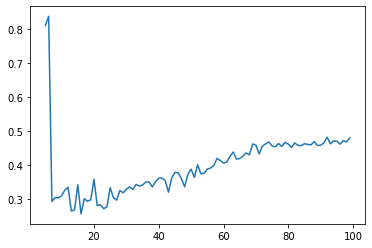

In [387]:
plt.plot(k_range, scores)

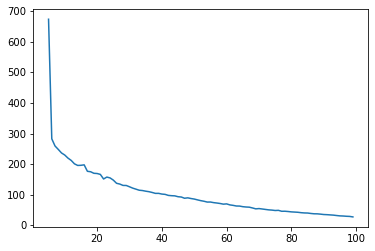

In [388]:
plt.plot(k_range, inertia)

In [389]:
#z=list(zip(k_range, scores))
#for i in z:
#    print(i)

In [390]:
cluster_size=17

In [391]:
km = KMeans(n_clusters=cluster_size, random_state=124)
km.fit(X)
df['Supervised']=km.labels_

/usr/lib/python3.9/site-packages/numpy/core/_asarray.py:102: FutureWarning:

The input object of type 'PngImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'PngImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.




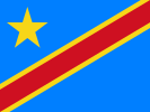
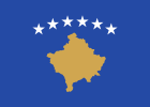
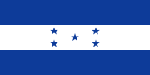
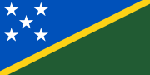
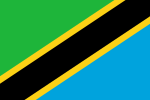
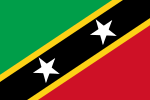
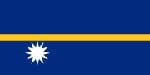
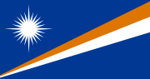
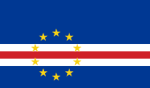
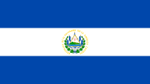
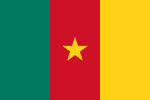
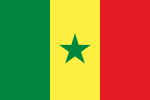
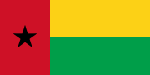
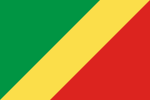
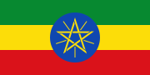
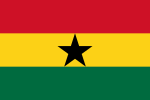
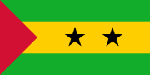
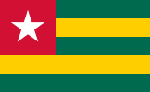
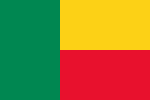
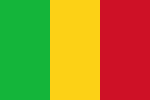
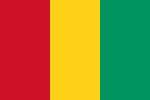
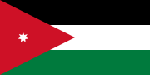
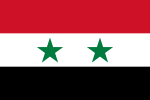
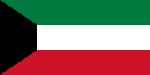
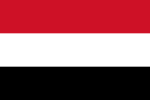
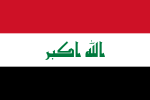
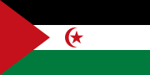
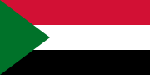
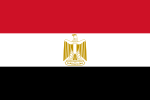
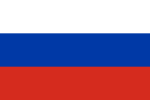
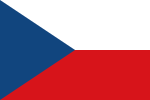
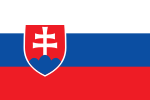
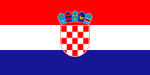
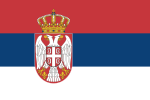
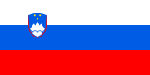
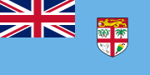
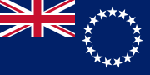
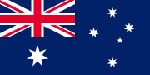
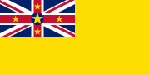
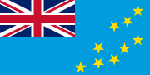
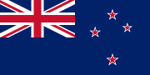
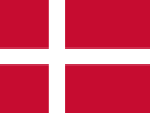
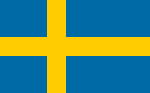
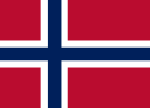
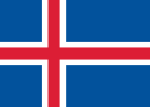
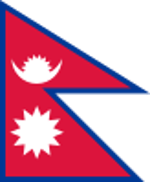
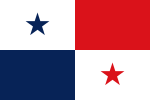
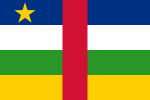
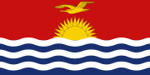
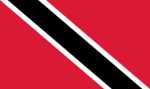
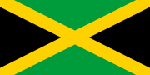
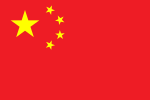
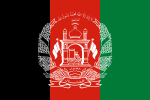
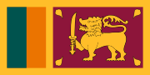
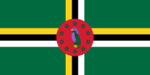
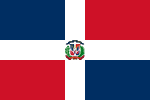
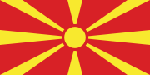
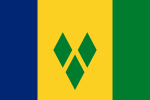
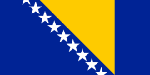
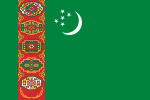
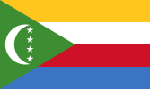
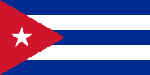
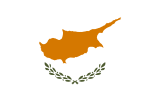
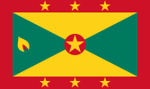
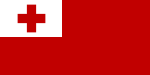
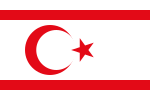
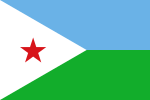
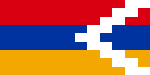
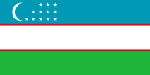
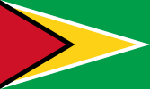
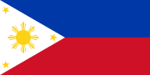
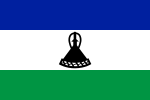
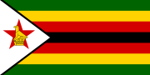
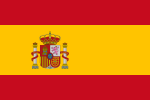
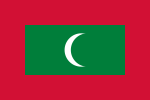
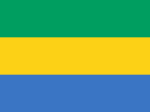
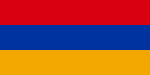
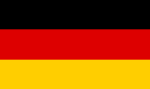
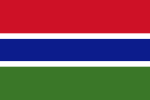
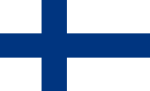
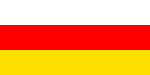
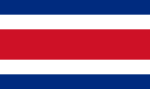
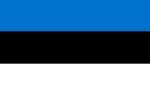
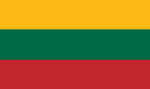
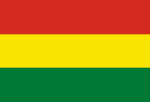
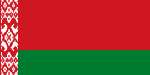
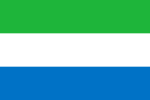
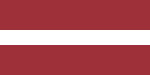
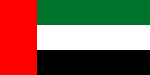
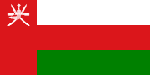
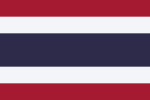
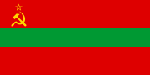
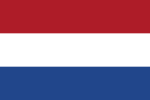
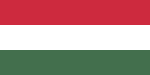
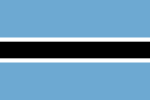
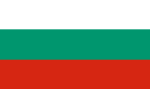
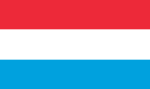
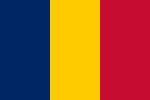
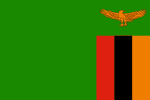
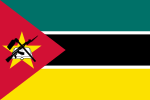
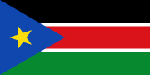
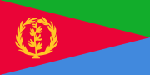
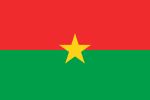
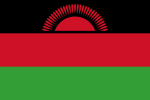
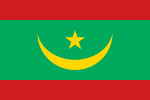
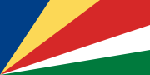
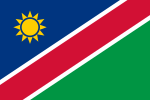
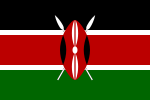
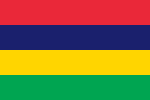
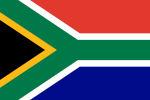
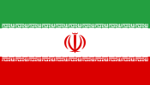
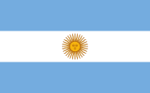
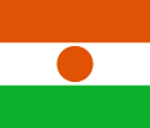
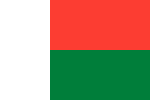
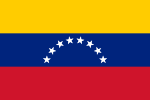
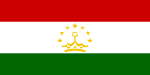
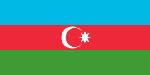
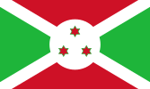
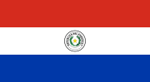
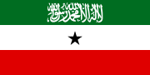
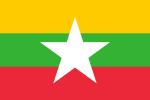
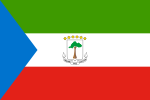
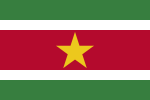
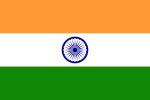
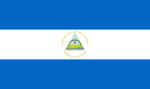
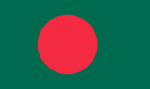
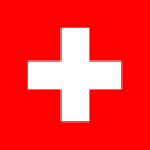
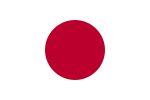
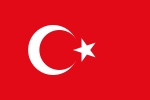
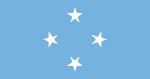
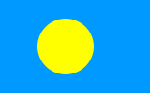
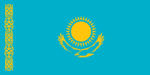
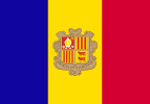
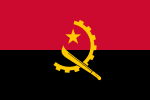
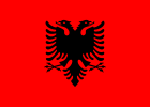
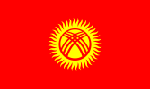
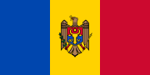
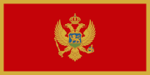
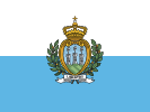
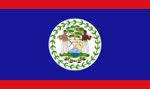
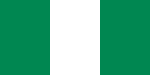
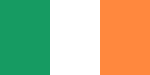
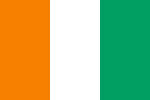
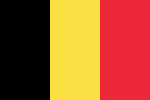
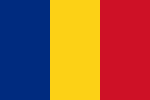
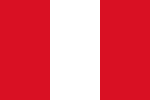
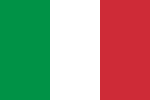
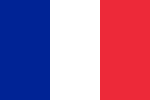
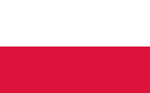
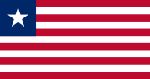
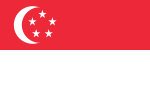
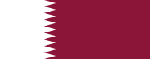
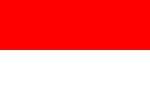
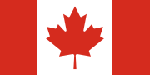
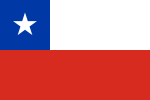
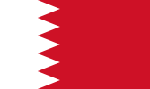
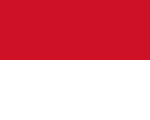
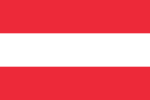
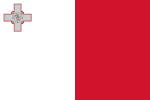
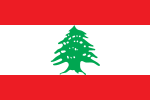
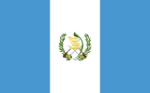
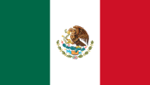
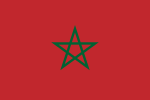
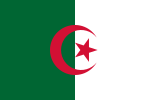
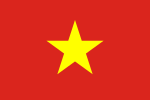
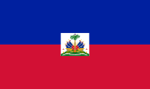
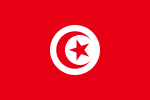
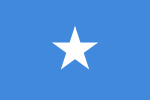
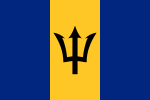
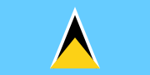
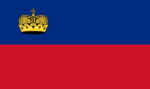
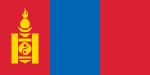
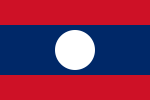
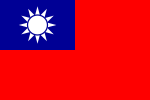
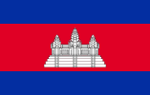
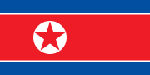
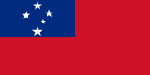
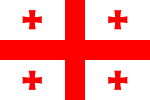
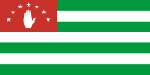
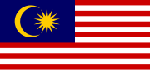
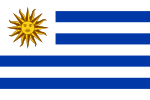
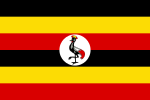
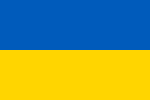
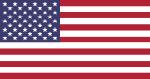
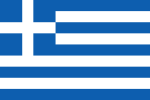


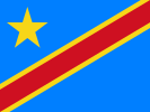
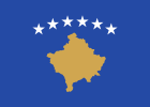
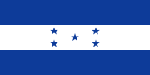
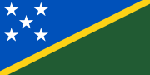
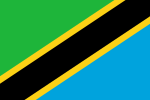
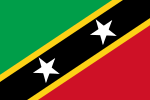
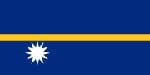
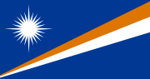
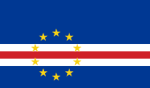
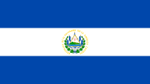
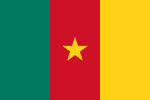
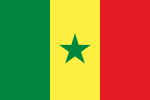
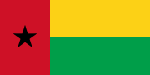
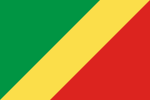
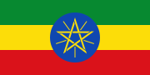
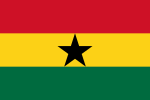
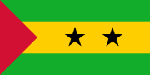
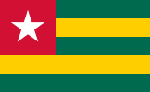
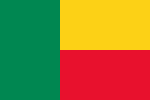
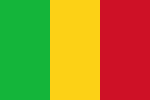
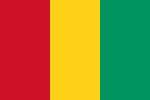
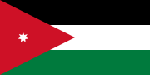
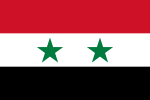
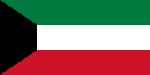
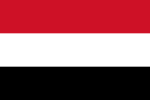
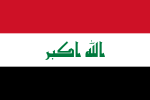
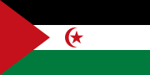
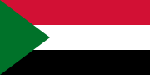
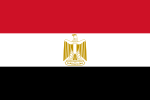
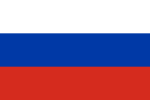
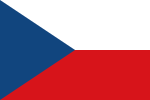
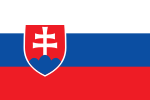
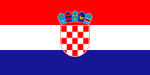
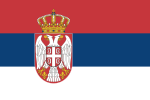
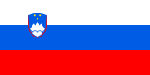
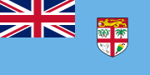
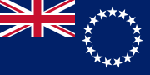
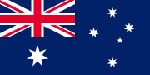
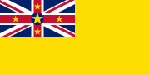
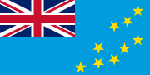
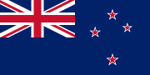
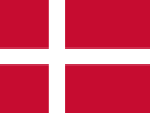
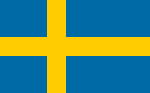
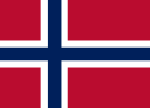
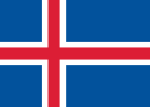
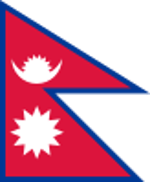
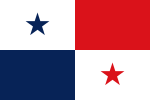
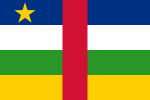
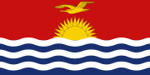
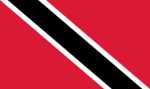
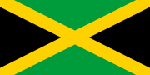
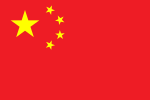
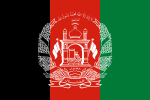
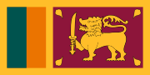
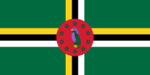
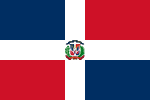
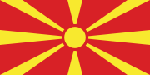
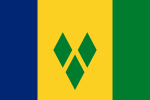
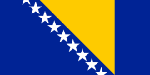
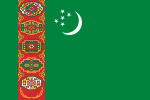
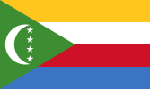
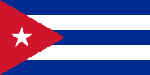
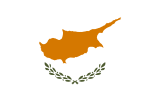
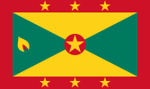
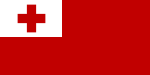
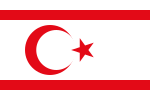
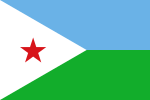
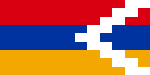
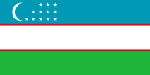
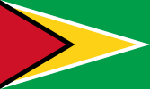
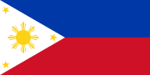
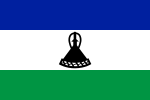
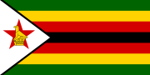
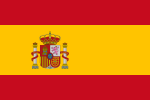
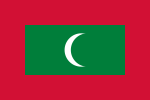
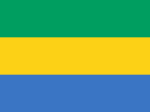
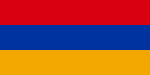
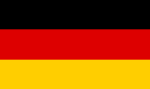
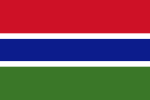
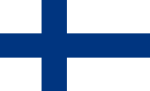
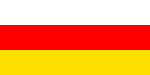
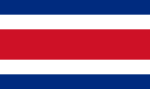
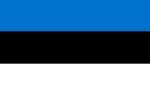
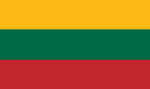
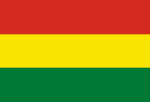
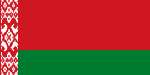
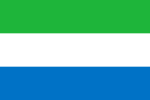
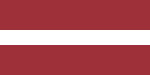
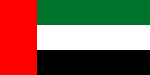
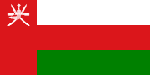
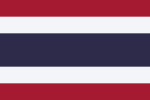
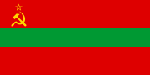
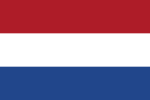
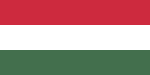
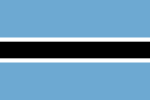
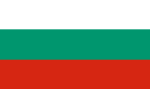
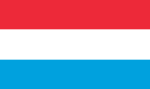
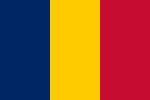
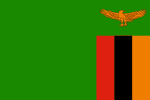
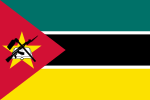
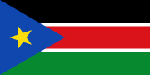
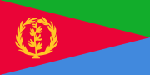
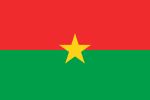
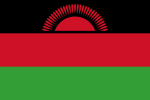
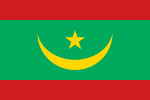
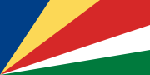
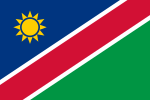
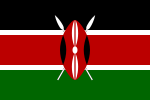
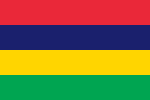
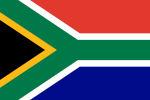
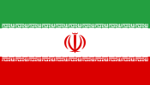
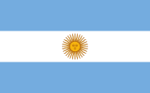
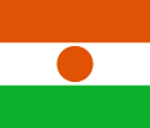
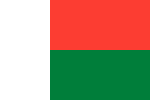
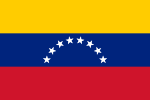
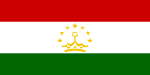
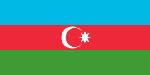
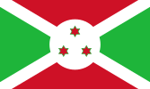
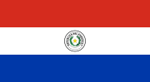
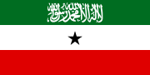
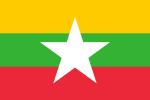
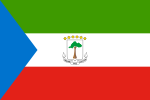
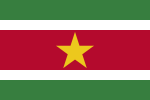
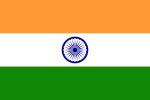
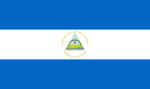
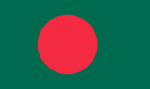
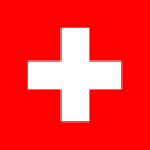
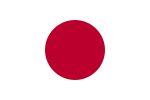
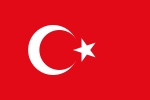
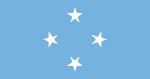
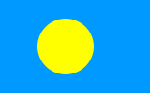
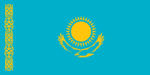
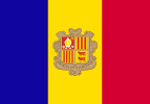
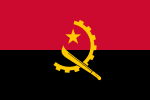
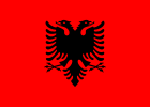
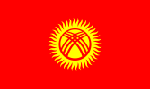
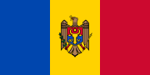
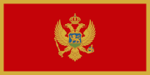
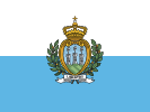
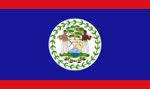
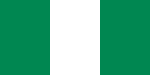
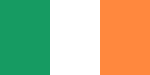
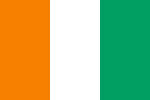
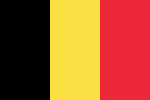
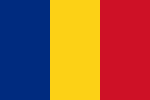
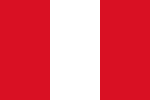
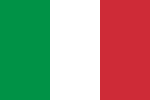
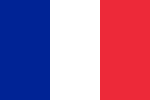
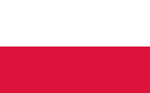
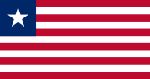
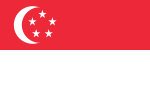
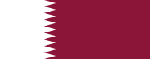
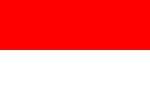
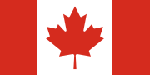
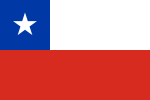
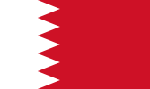
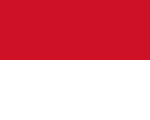
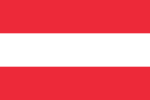
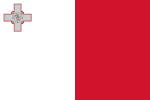
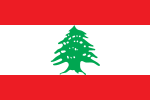
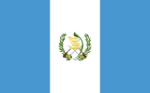
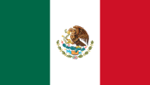
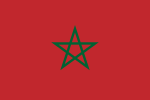
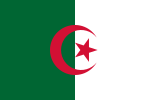
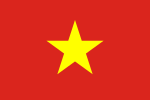
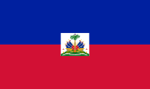
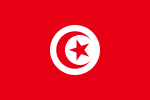
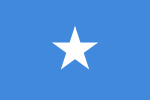
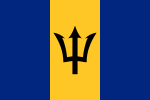
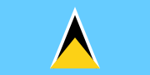
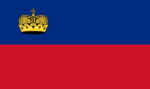
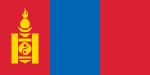
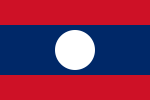
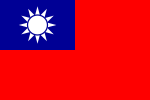
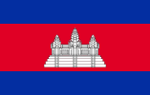
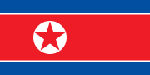
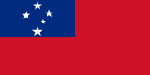
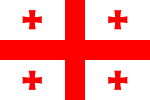
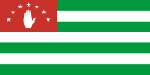
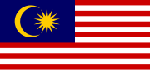
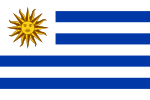
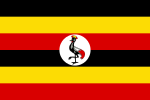
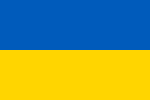
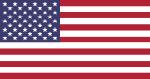
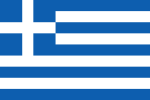

In [392]:
view_cluster(df, 'Supervised')